# Standard scanpy workflow version 2.8 #


Data loaded here is the concatenation of the human samples of islet cells load from GSE84133.

Inital processing step was by reading all individual samples and using concatenate from scanpy.


Here, no filtering will be performed initially but 

### Import section ###

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
absl                NA
anndata             0.7.5
annoy               NA
attr                20.3.0
backcall            0.2.0
bbknn               NA
besca               2.4+57.g5ad53b2
biothings_client    0.2.1
cached_property     1.5.2
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
deprecate           0.3.0
dominate            2.6.0
fbpca               NA
fsspec              2021.06.1
future_fstrings     NA
get_version         2.1
google              NA
h5py                3.1.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
importlib_metadata  1.7.0
intervaltree        NA
ipykernel           5.4.2
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi 

## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [2]:
# decisions to be made
species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name =  'standard_workflow_besca2.0_without_regress_out'
split_condition = 'Individual' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'assigned_cluster'# must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'assigned_cluster' # define name under which the labeling should be exported
labeling_description = 'celltype annotation from the paper' #define description which should be saved to labeling_info file
labeling_author = 'Baron' #define author which shoudl be saved to labeling info file

### Define Input ###

In [3]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()

### Standard parameters - these should be kept as stable as possible ###

In [4]:
# the standard parameter section
standard_min_genes = 500
standard_min_cells = 30
standard_min_counts = 1000
standard_n_genes = 5000 # this is the most tricky one to set
standard_percent_mito = 0.1
standard_max_counts = 140000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [5]:
#define standardized filepaths based on above input
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

#read input data

#adata = sc.read_h5ad('raw/all_samples.h5ad')#bc.st.read_matrix(root_path)
adata = bc.datasets.Baron2016_processed()
adata = bc.subset_adata(adata, adata.obs_names, raw=True)
adata.raw = adata

LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2021-07-20
LOG MESSAGE: Analysis 'standard_workflow_besca2.0_without_regress_out' on data located in'/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 500
LOG MESSAGE: 	standard_min_cells = 30
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 5000
LOG MESSAGE: 	standard_max_counts = 140000
LOG MESSAGE: 	standard_percent_mito = 0.1
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.016s


all output directories created successfully


# Dataset specific adaptation

We use an ad-hoc script to find ensembl id for the genes symbol and input this into our anndata object.
Additional, X is transformed into a sparse matrix.

# Continuing standard_workflow

### Visualization of quality control plots and selected filtering parameters

<AxesSubplot:xlabel='Counts'>

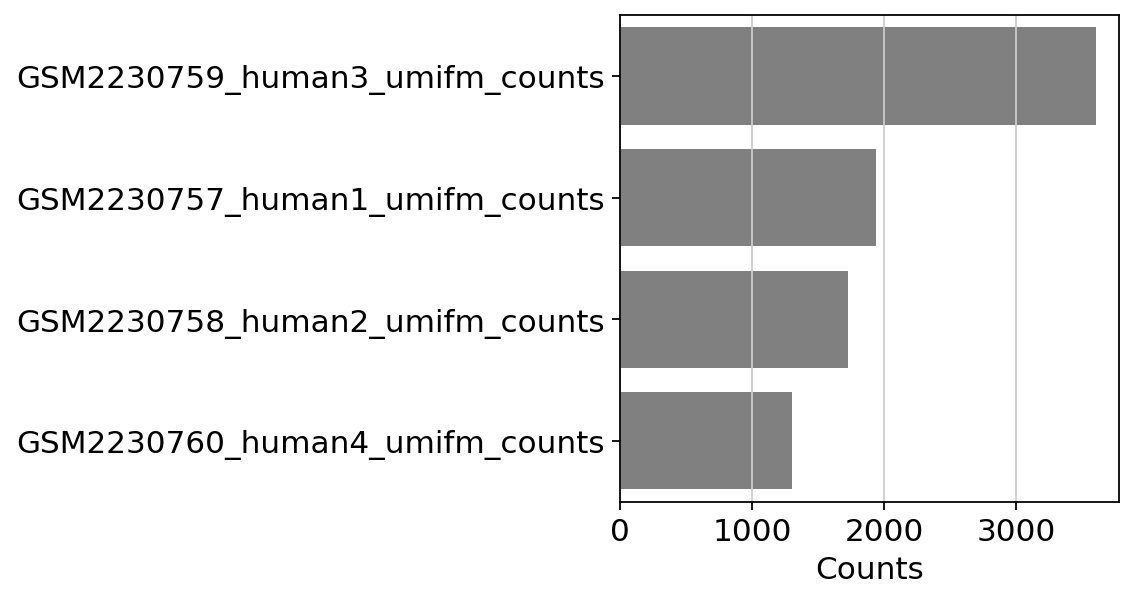

In [6]:
### have a look at cell nrs per sample ### 
temp=bc.tl.count_occurrence(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

# Additional visualization using metadata from publication



<AxesSubplot:xlabel='Counts'>

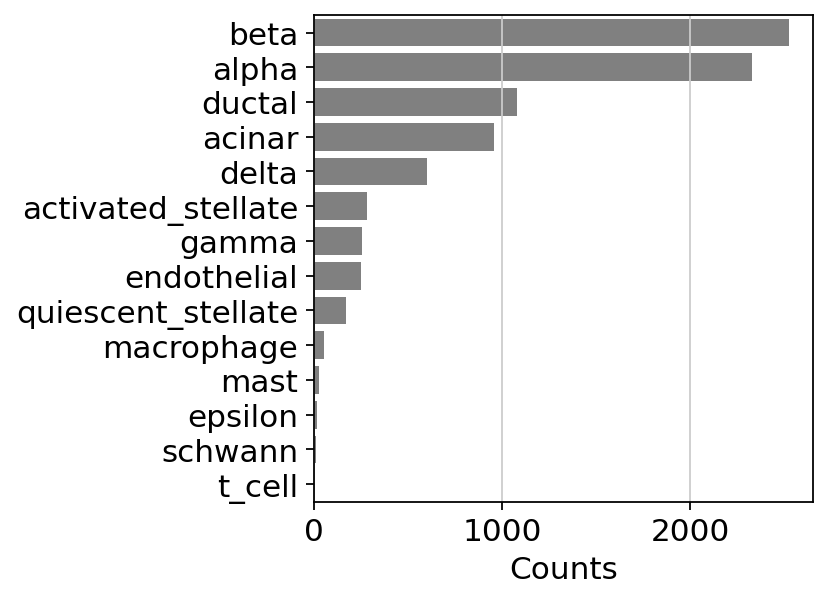

In [7]:
temp=bc.tl.count_occurrence(adata,'assigned_cluster')
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

##### Transcript Capture Efficiency
This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

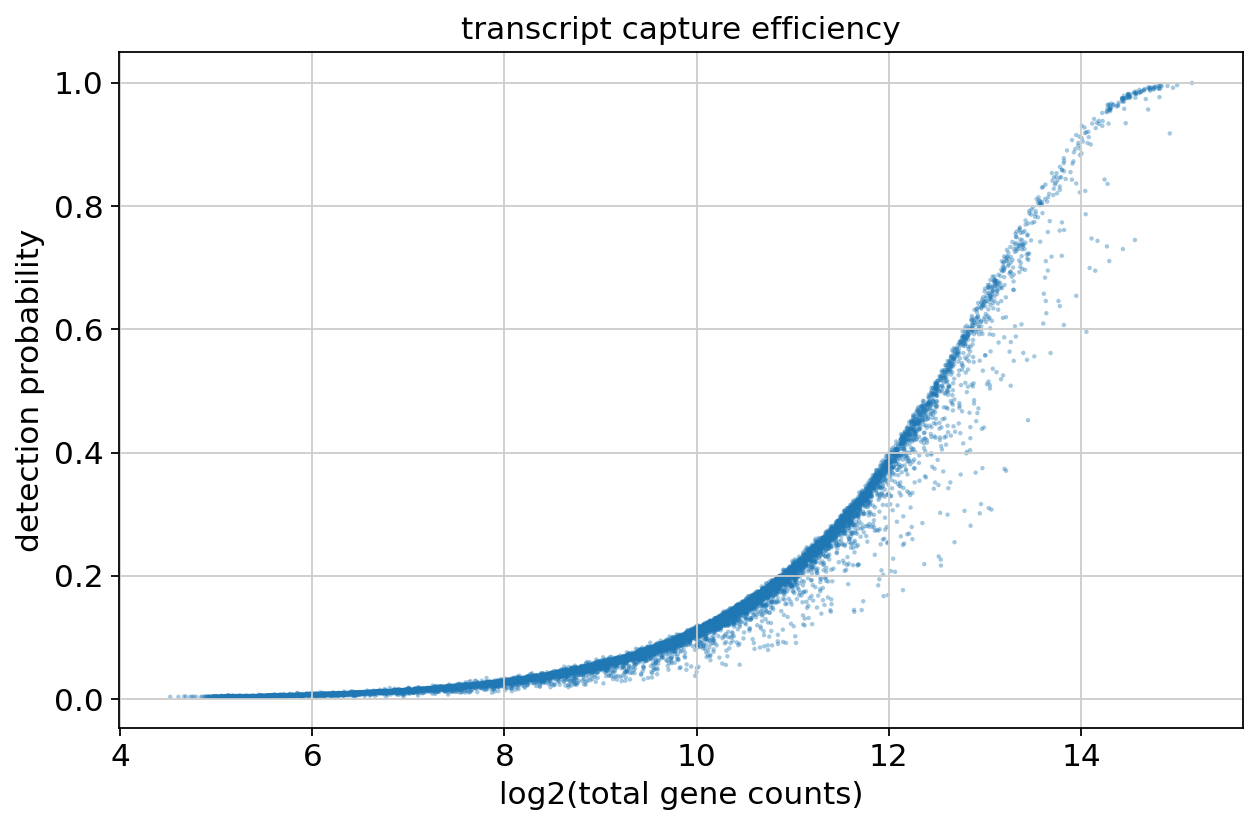

In [8]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

##### Library Size distribution
This plot gives you an idea about the library size distribution in your dataset before processing.

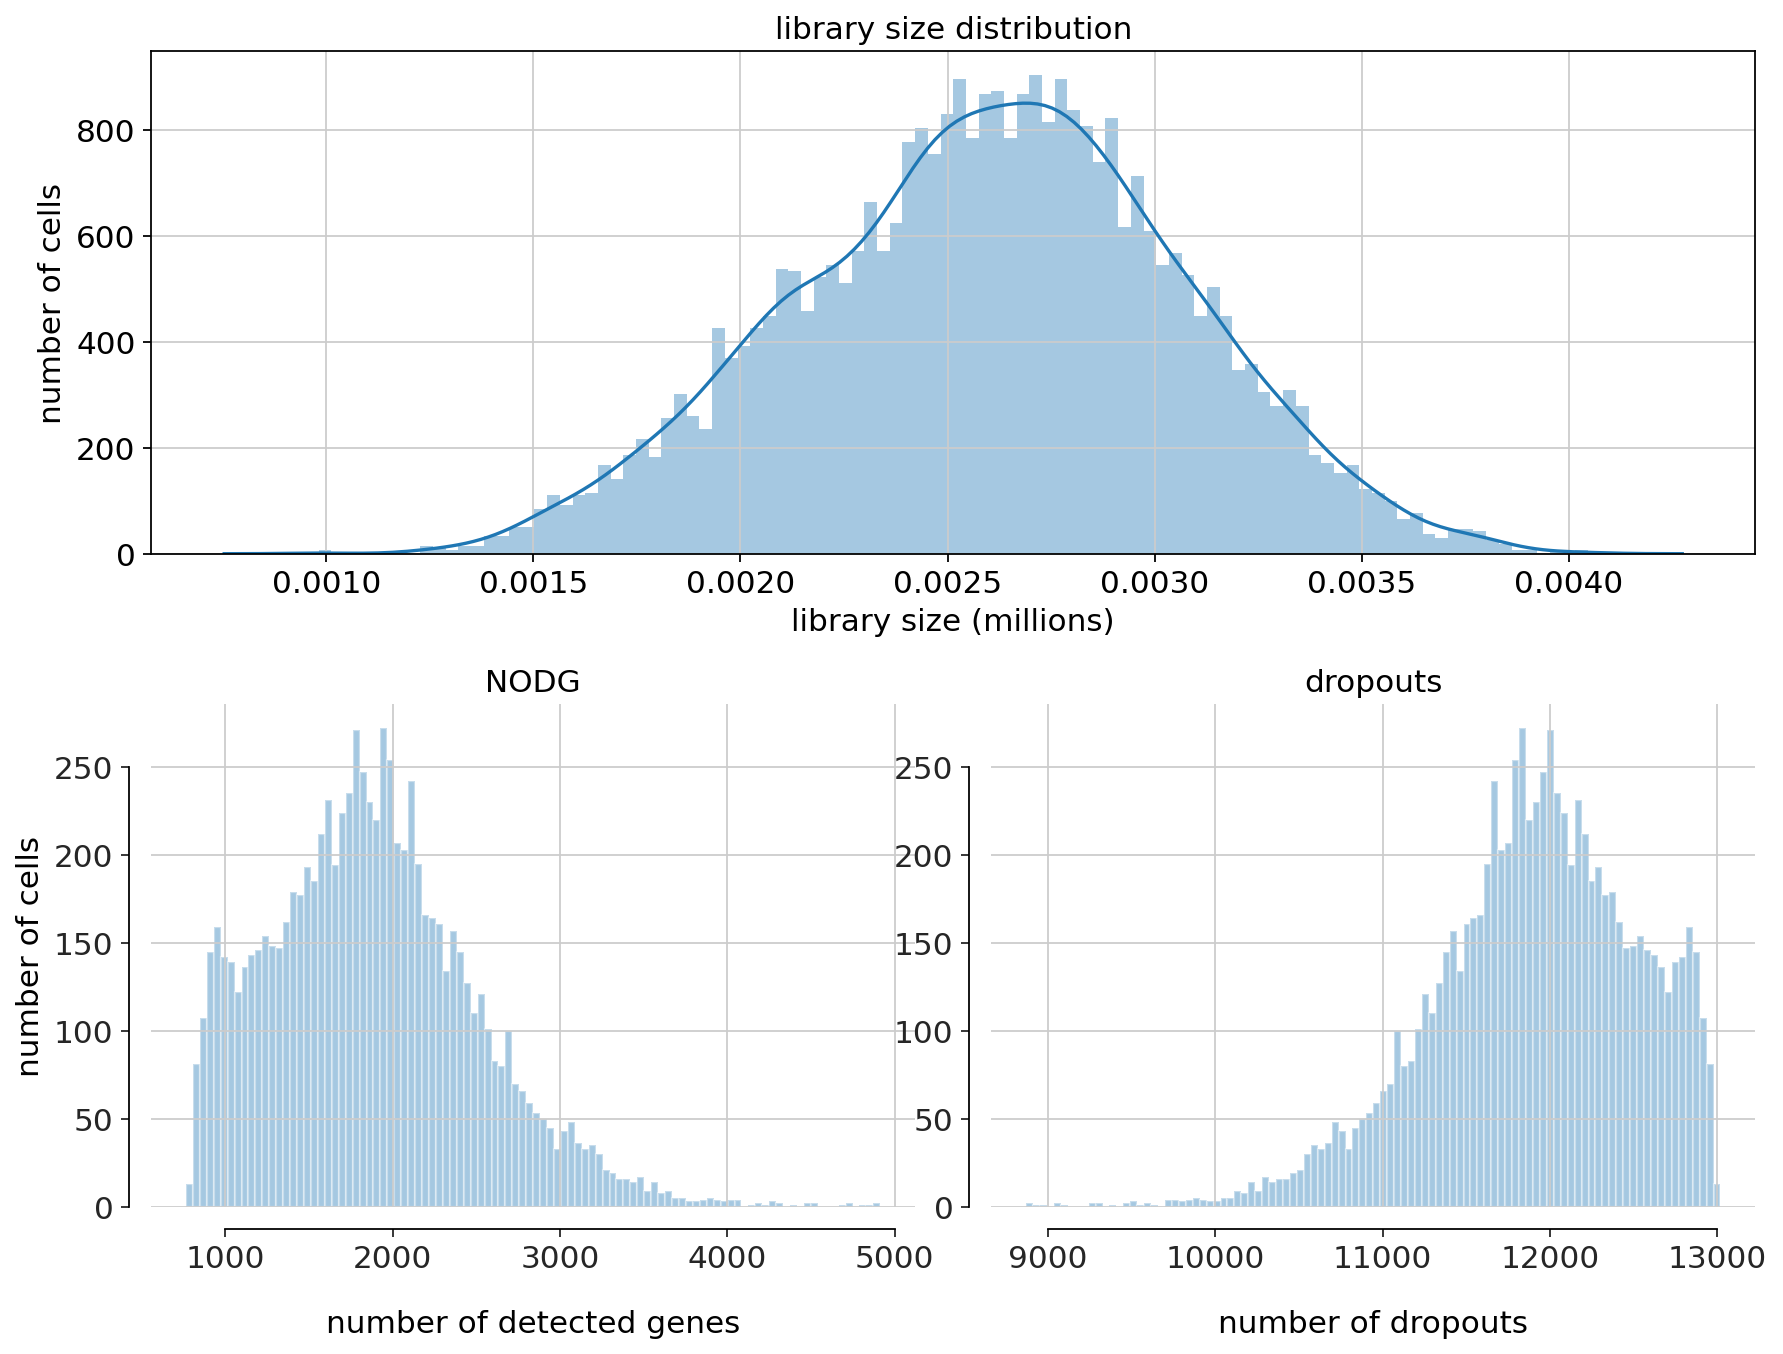

In [9]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [10]:
adata_unfiltered = adata.copy()


##### Selected Filtering Parameters

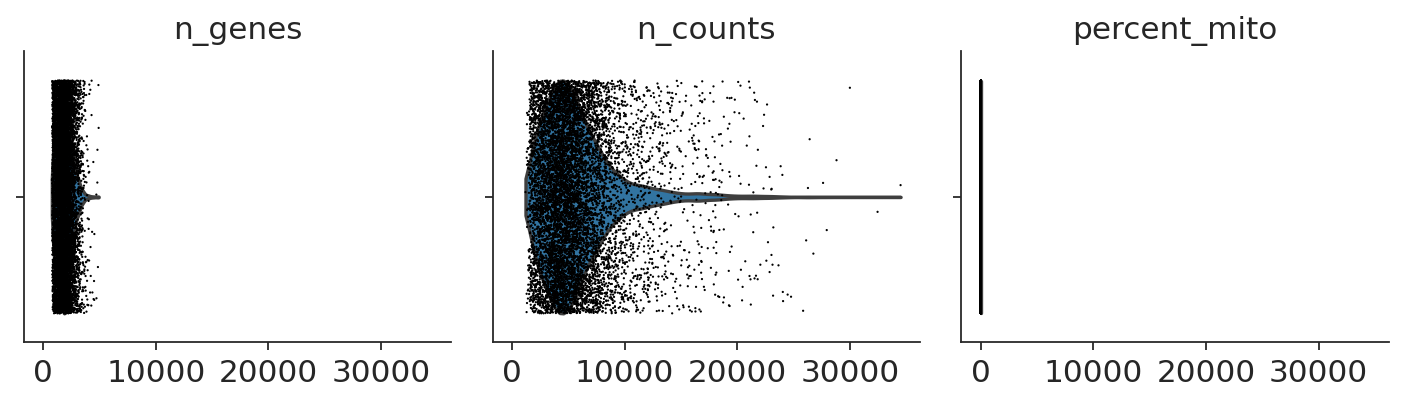

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.before_filtering.png')

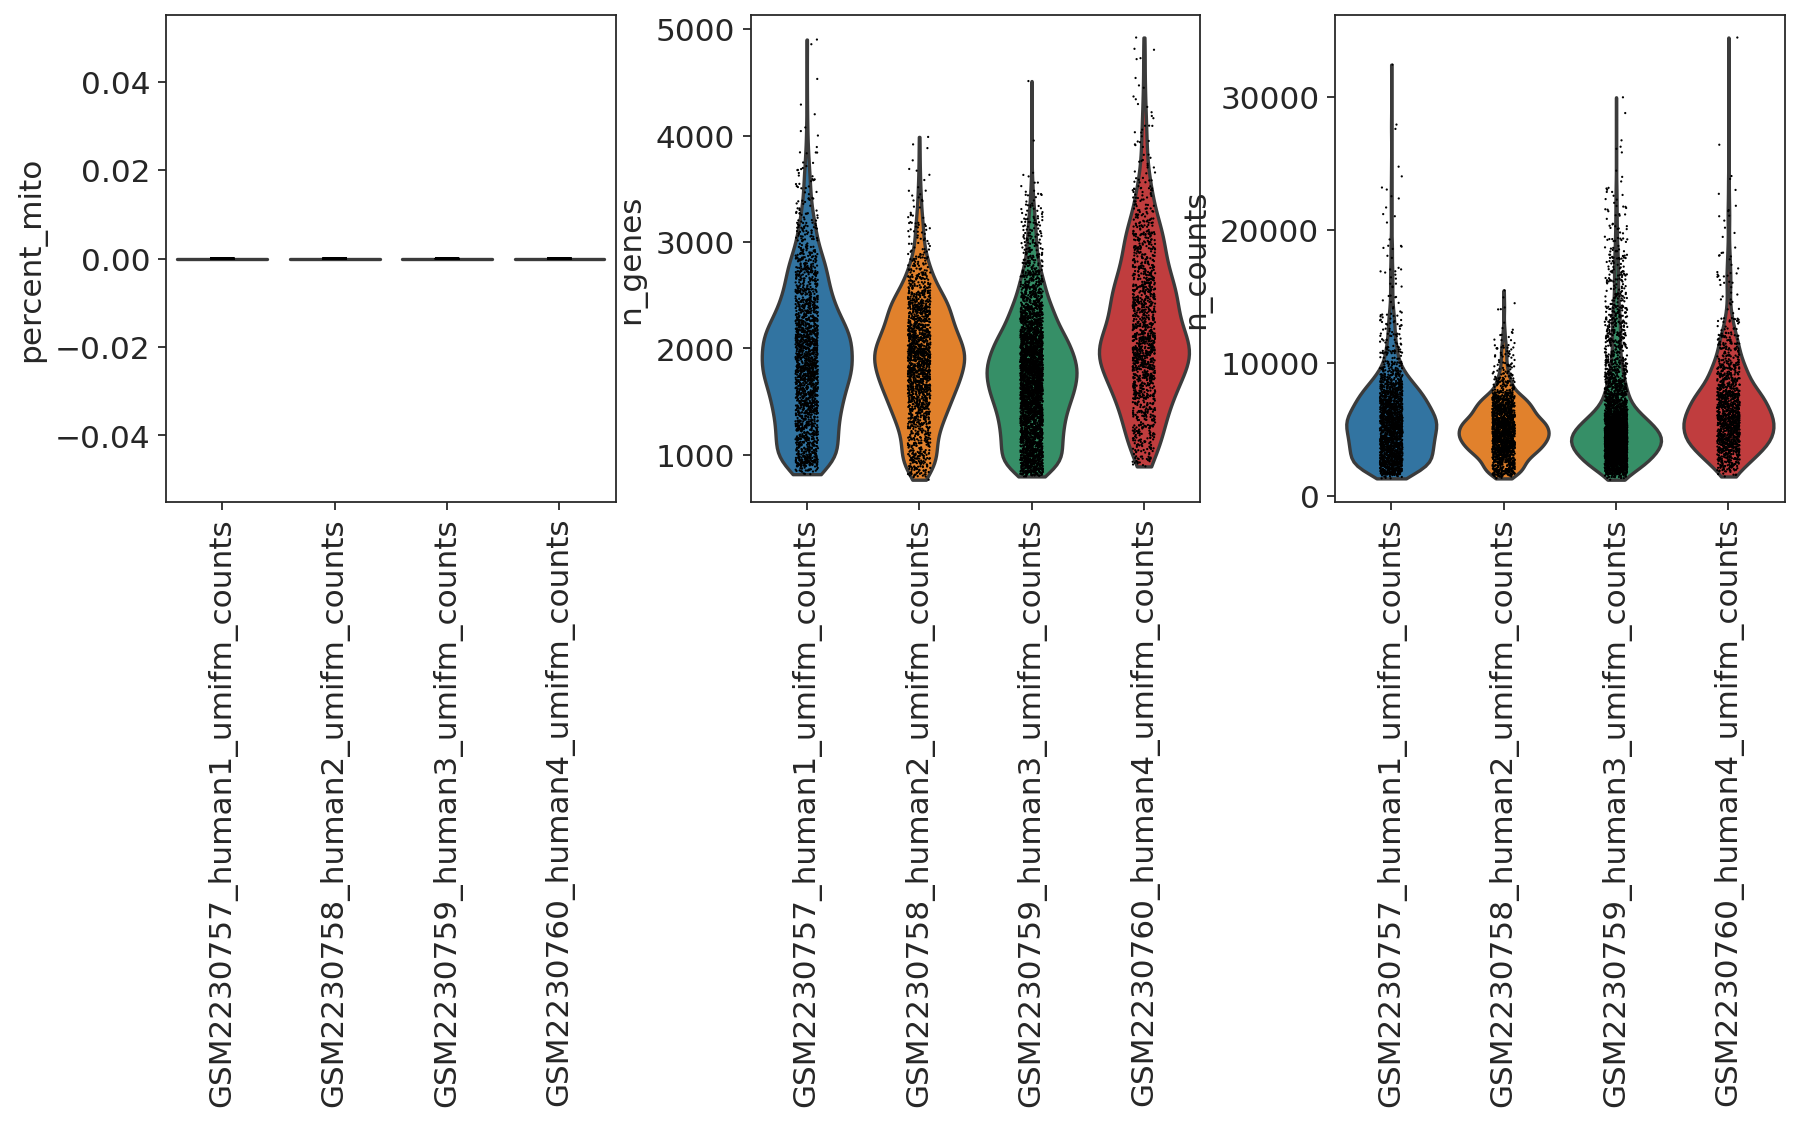

In [12]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### First filtering on gene and cell counts

In [13]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 8569 cells, 13784 genes
LOG MESSAGE: 	Time for filtering: 0.646s


In [14]:
filtering1.show()

started with  8569  total cells and  13784  total genes
removed 0 cells that did not express at least 500  genes
removed 0 cells that did not have at least 1000 counts
removed 0 genes that were not expressed in at least 30 cells
finished with 8569  total cells and 13784 total genes


### Second filtering on mitochondrial genes, and upper limit for gene number ###

In [15]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 8569 cells, 13784 genes
LOG MESSAGE: 	Time for filtering: 0.592s


In [16]:
filtering2.show()

started with  8569  total cells and  13784  total genes
removed 0 cells that expressed more than 5000 genes
removed 0 cells that had more than 140000  counts
removed  0  cells that expressed  10.0 percent mitochondrial genes or more
finished with 8569  total cells and 13784 total genes


###  Filtered dataset characteristics

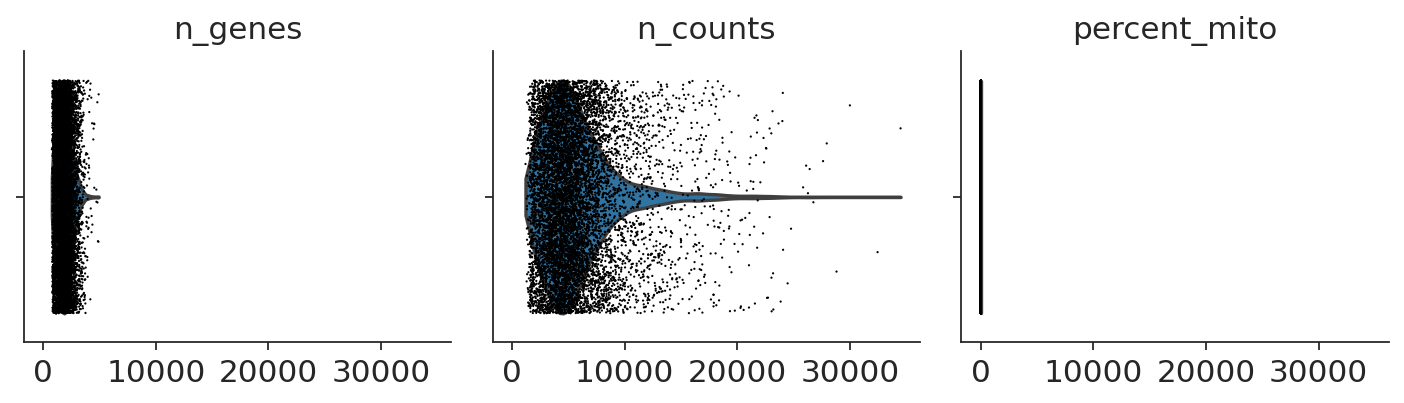

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

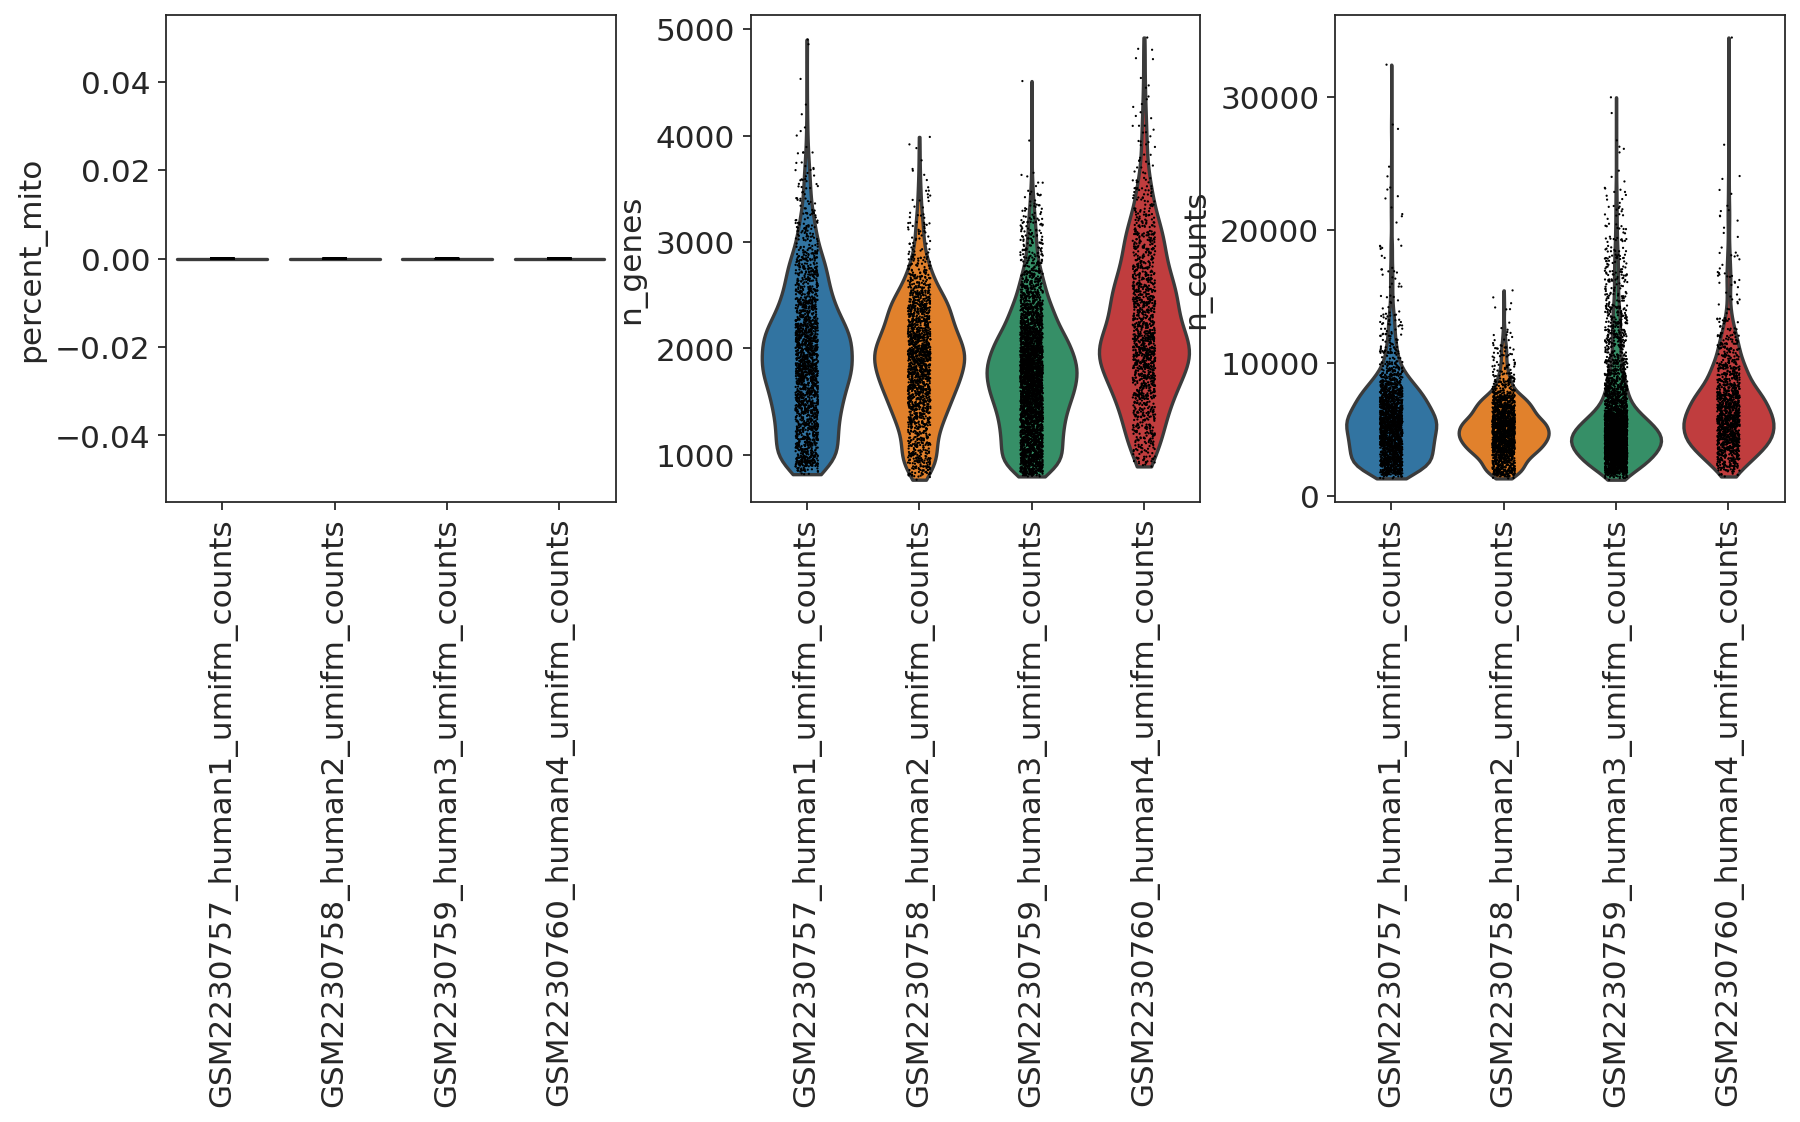

In [18]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

### Per-cell normalization, and output of normalized results ###

In [19]:
dynrange

['B2M', 'ACTB', 'PGK1', 'CTCF']

<Figure size 320x320 with 0 Axes>

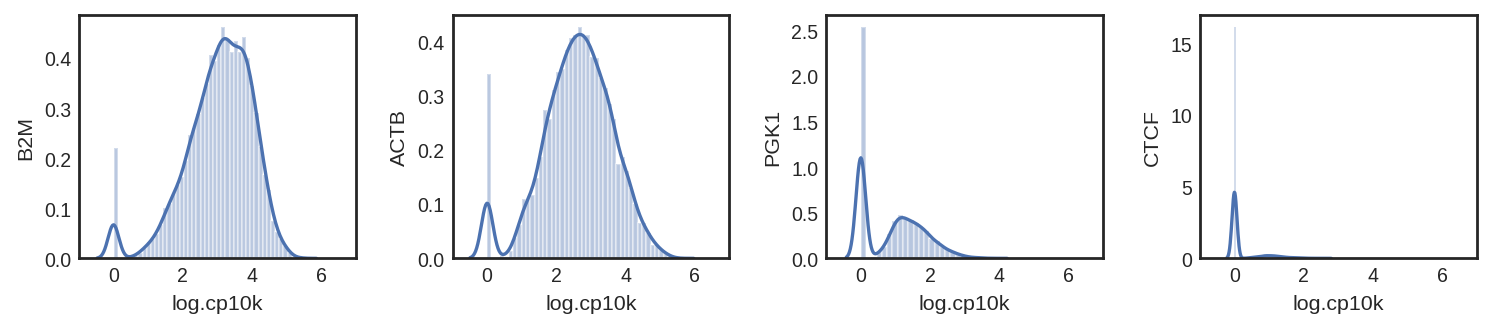

In [20]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')
    


### No regression step

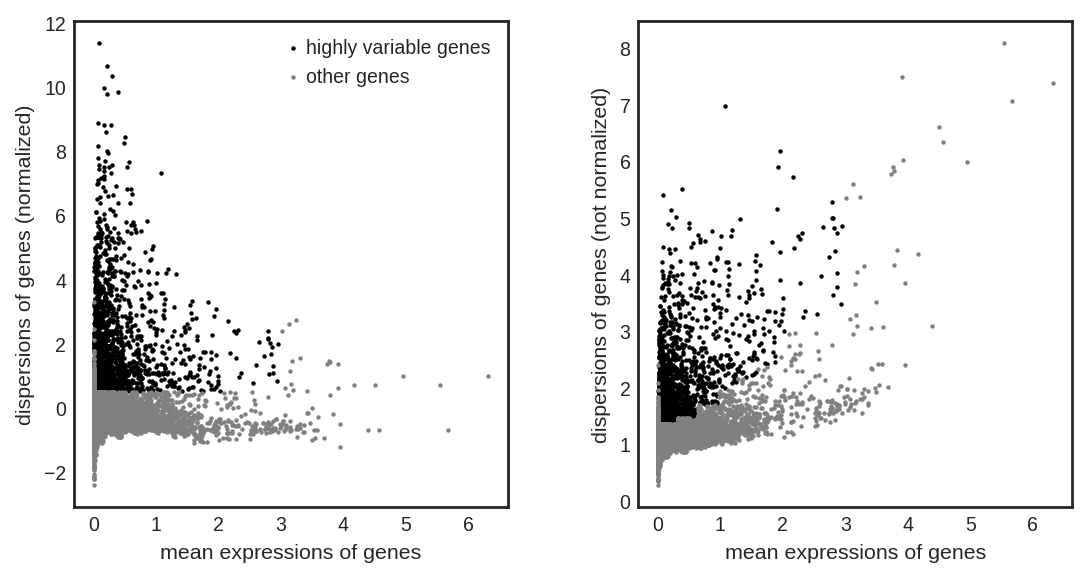

After feature selection of highly variable genes: 8569 cells, 1839 genes
adata scaled with max_value set to 10


In [21]:
#sc.pp.log1p(adata)
#print('log1p taken of adata')

#adata = adata.copy()
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
#print("'n_counts' and 'percent_mito' regressed out")

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
sc.pl.highly_variable_genes(adata, save='.hvg.png', show=True)
adata = adata[:, adata.var.highly_variable == True]
print('After feature selection of highly variable genes: ' +
             str(adata.shape[0])+' cells, ' + str(adata.shape[1])+' genes')

sc.pp.scale(adata, max_value=10)
print('adata scaled with max_value set to 10')

In [22]:
adata

AnnData object with n_obs × n_vars = 8569 × 1839
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Individual_colors', 'hvg'

### Feature selection (highly variable genes) for clustering (skipped) ###

In [23]:
#adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data (skipped) ###

In [24]:
#adata 

In [25]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
#adata = adata.copy()
#adata = bc.st.regress_out(adata, results_folder)

### Batch correction and PCA neighbor analysis and UMAP

The standard workflow uses bbknn as  batch correction method.


Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


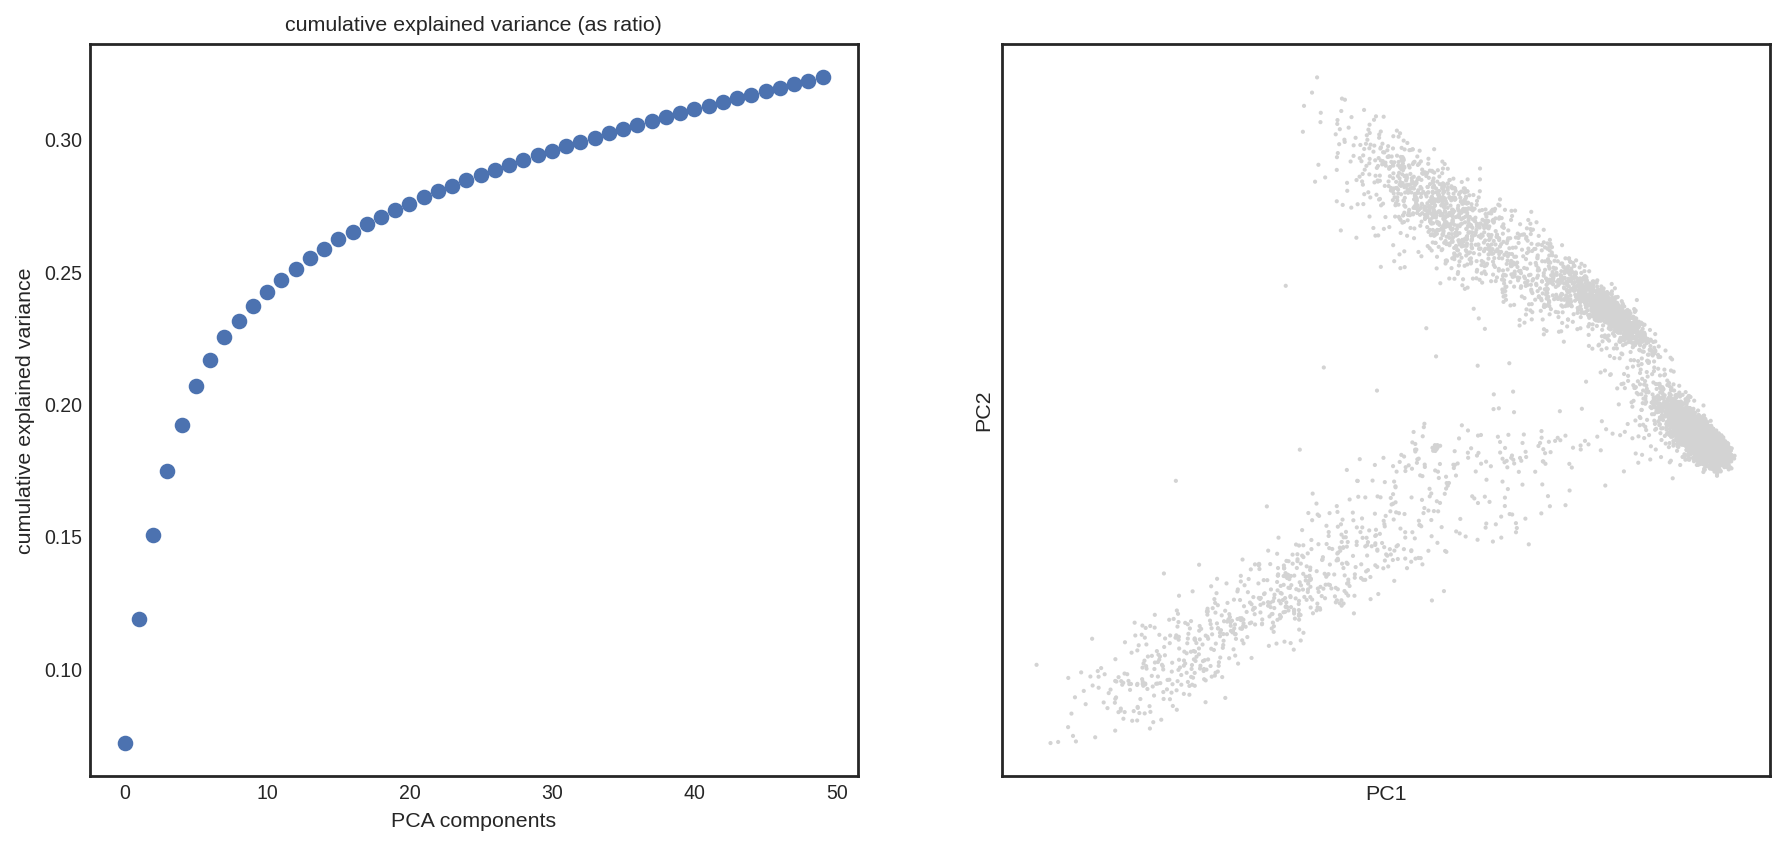

Nearest neighbors calculated with n_neighbors = 10


LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 30.009s
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.13s


UMAP coordinates calculated.
results successfully written out to 'analysis_metadata.tsv'


In [26]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering ###

leiden clustering performed with a resolution of 1


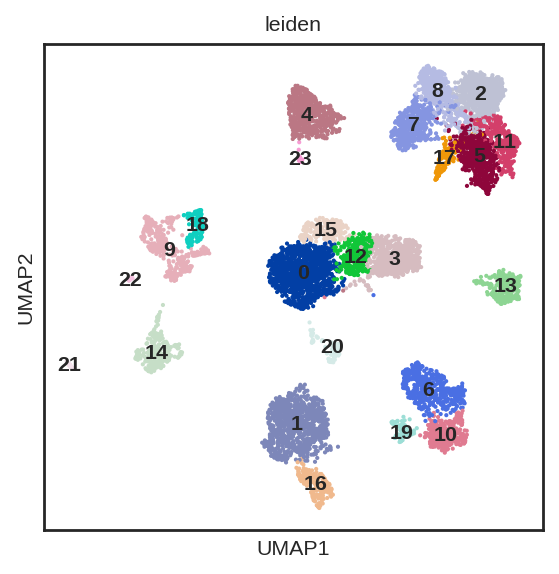

LOG MESSAGE: leidenclustering done. Found 24 clusters.
LOG MESSAGE: 	Time for leiden clustering: 0.972s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 11.002s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/leiden/WilxRank.gct written out
/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 3.764s


/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/leiden/WilxRank.logFC.gct written out


In [27]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [28]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/standard_workflow_besca2.0_without_regress_out.h5ad


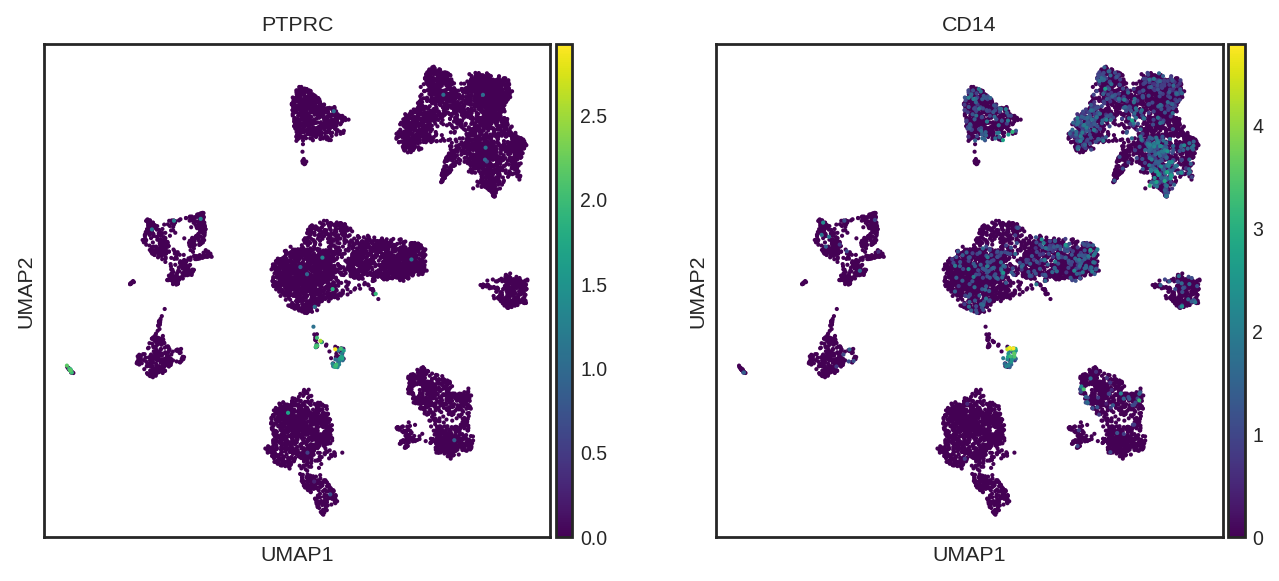

In [29]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

### Additional Labeling ###

(if specified) based on external annotation in "metadata.tsv"  the additional labeling will be exported to file and the fract_pos.gct and average.gct files generated

In [30]:
adata

AnnData object with n_obs × n_vars = 8569 × 1839
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Individual_colors', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

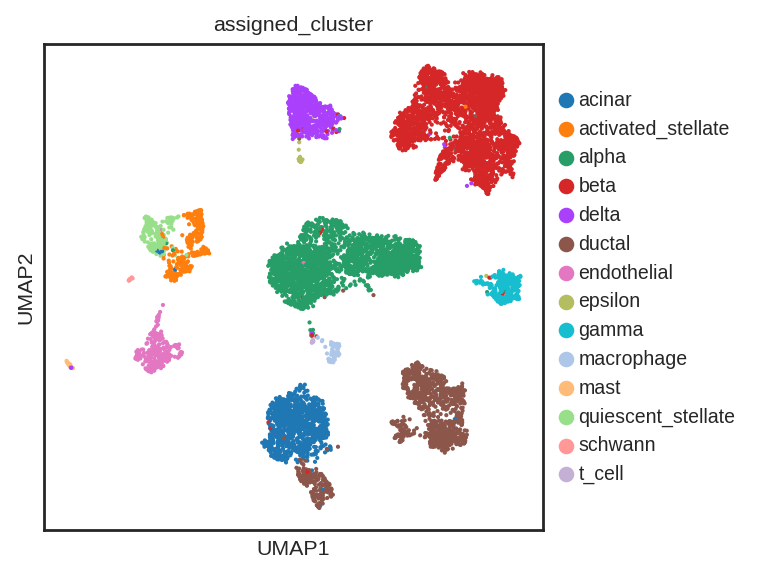

In [31]:
sc.pl.umap( adata, color  = ['assigned_cluster'] )

In [32]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

mapping of cells to  assigned_cluster exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out


LOG MESSAGE: Marker gene detection performed on a per-label basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 9.089s


rank genes per label calculated using method wilcoxon.
/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/assigned_cluster/WilxRank.gct written out
/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/assigned_cluster/WilxRank.pvalues.gct written out


LOG MESSAGE: Label level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 11.693s


/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Baron2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/assigned_cluster/WilxRank.logFC.gct written out


### Complete log-file

In [33]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 72.063s


### Write QC Report

In [34]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

LOG MESSAGE: QC Report generated and saved as .html


### Comparison to original standard workflow

In [35]:
adata

AnnData object with n_obs × n_vars = 8569 × 1839
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Individual_colors', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'assigned_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
# Read the results file from the original standard workflow
adata_std = bc.datasets.Baron2016_processed()
adata_std

AnnData object with n_obs × n_vars = 8569 × 1839
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'Individual_colors', 'assigned_cluster_colors', 'celltype0_colors', 'celltype1_colors', 'celltype2_colors', 'celltype3_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

HVGs regress out before feature selection: 1839
HVGs feature selection before regress out: 1839
HVGs intersection: 1839


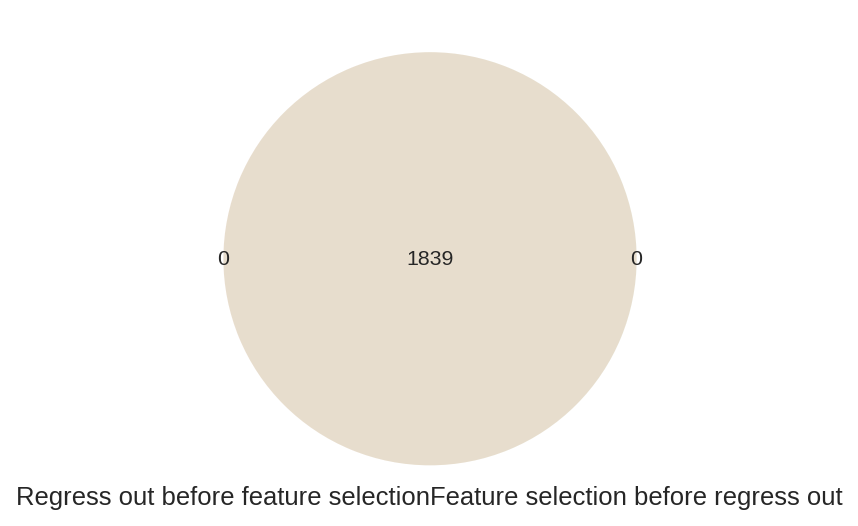

In [37]:
# Intersection of highly variable genes (HVG) and Venn diagram

hvg_adata = adata.var_names
hvg_adata_std = adata_std.var_names
hvg_intersection = list(set(hvg_adata) & set(hvg_adata_std))

print('HVGs regress out before feature selection: ' + str(len(hvg_adata)))
print('HVGs feature selection before regress out: ' + str(len(hvg_adata_std)))
print('HVGs intersection: ' + str(len(hvg_intersection)))

from matplotlib_venn import venn2
venn2(
    subsets = (len(hvg_adata)-len(hvg_intersection), len(hvg_adata_std)-len(hvg_intersection), len(hvg_intersection)), 
    set_labels = ('Regress out before feature selection', 'Feature selection before regress out')
)

In [38]:
# Add labelings from original workflow for comparison
adata.obs = adata.obs.join(adata_std.obs['leiden'], rsuffix='_std')

acc: 0.33
f1: 0.33
ami: 0.91
ari: 0.89
silhouette leiden_std: 0.45
silhouette leiden: 0.45
pair confusion matrix:
          0        1
0  67675048   418064
1    689238  4636842


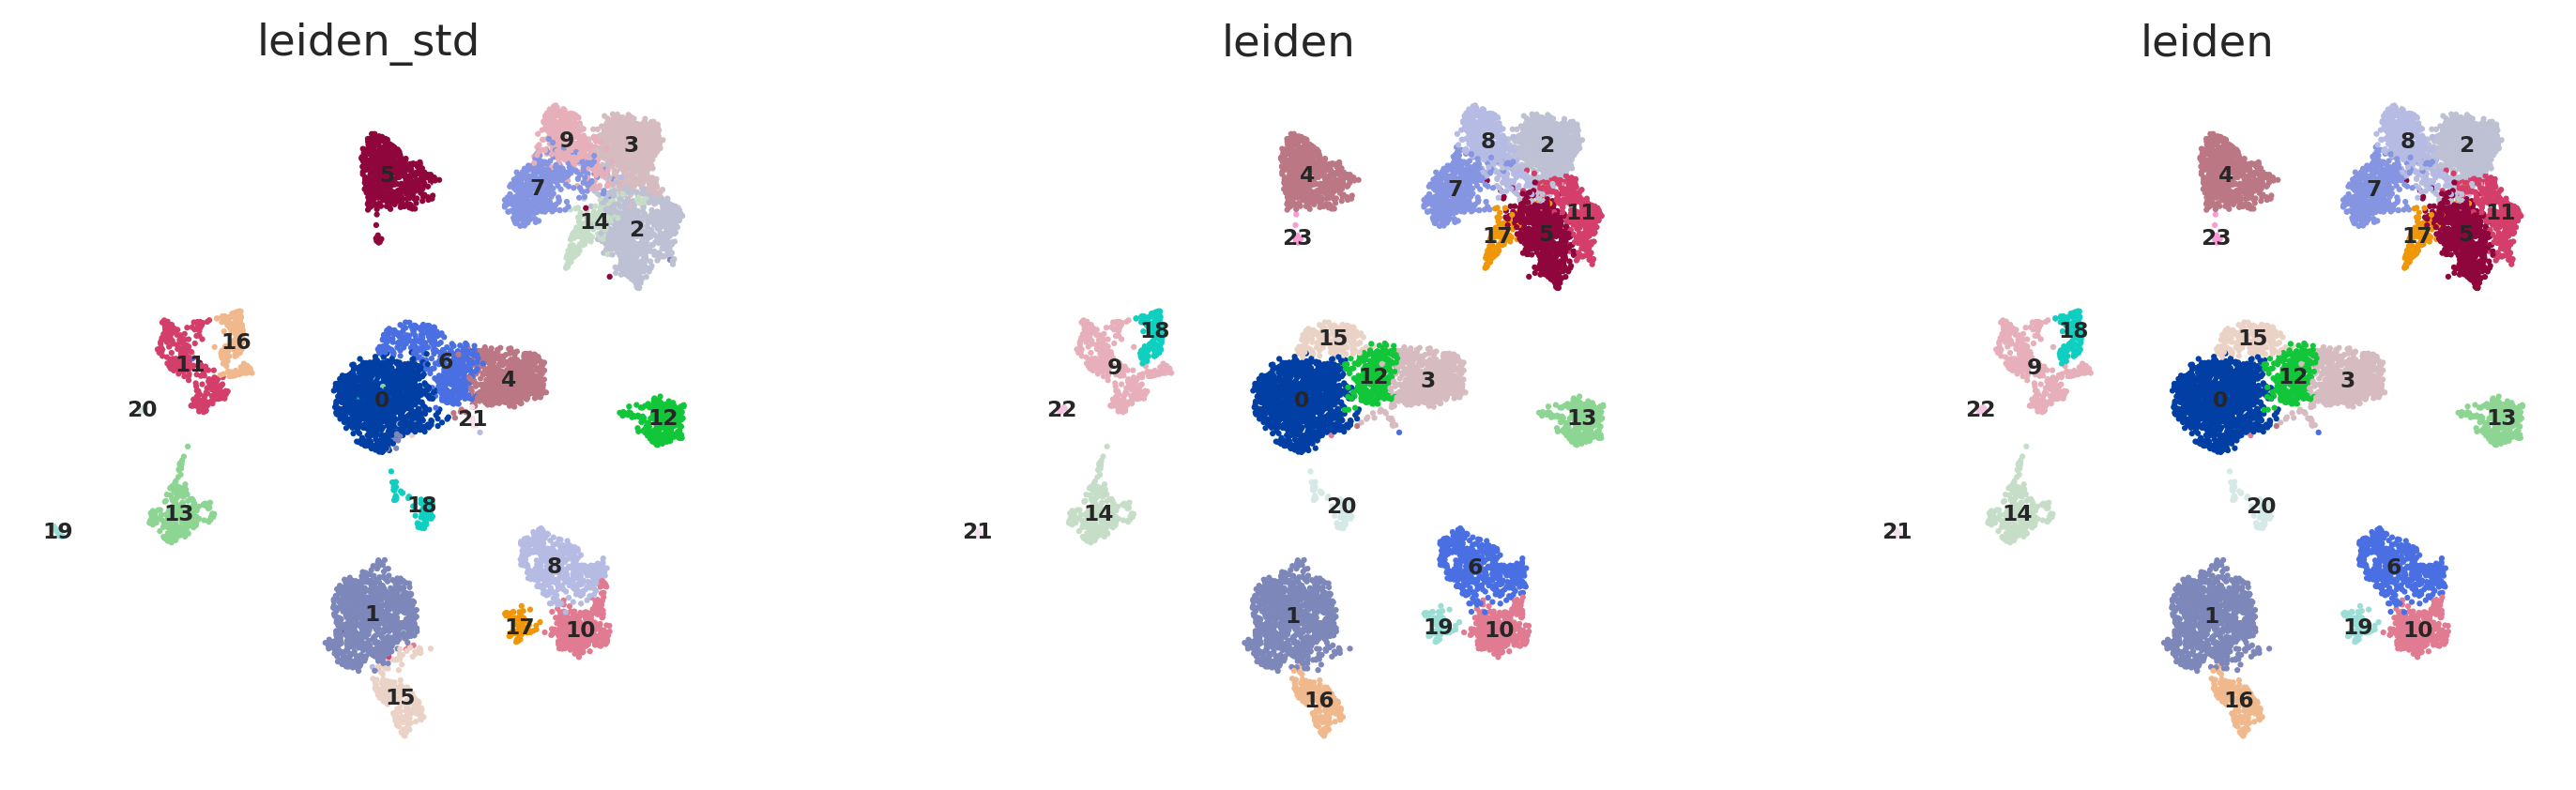

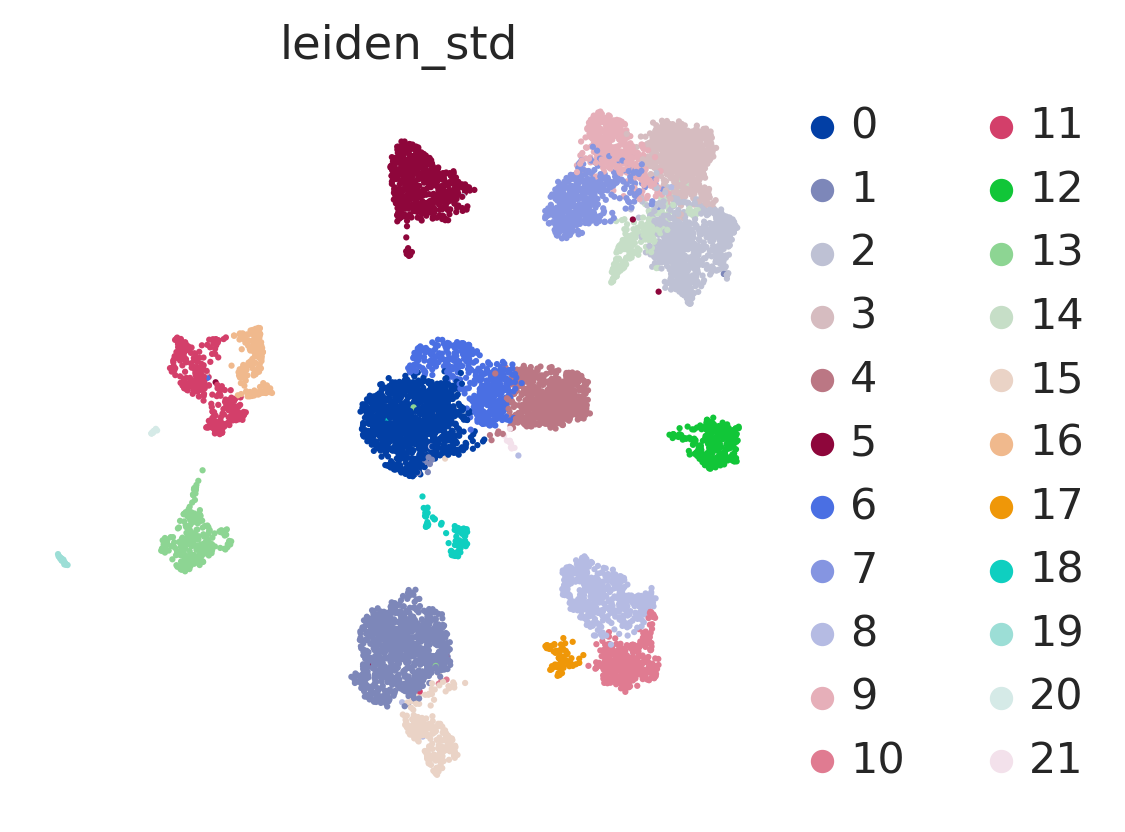

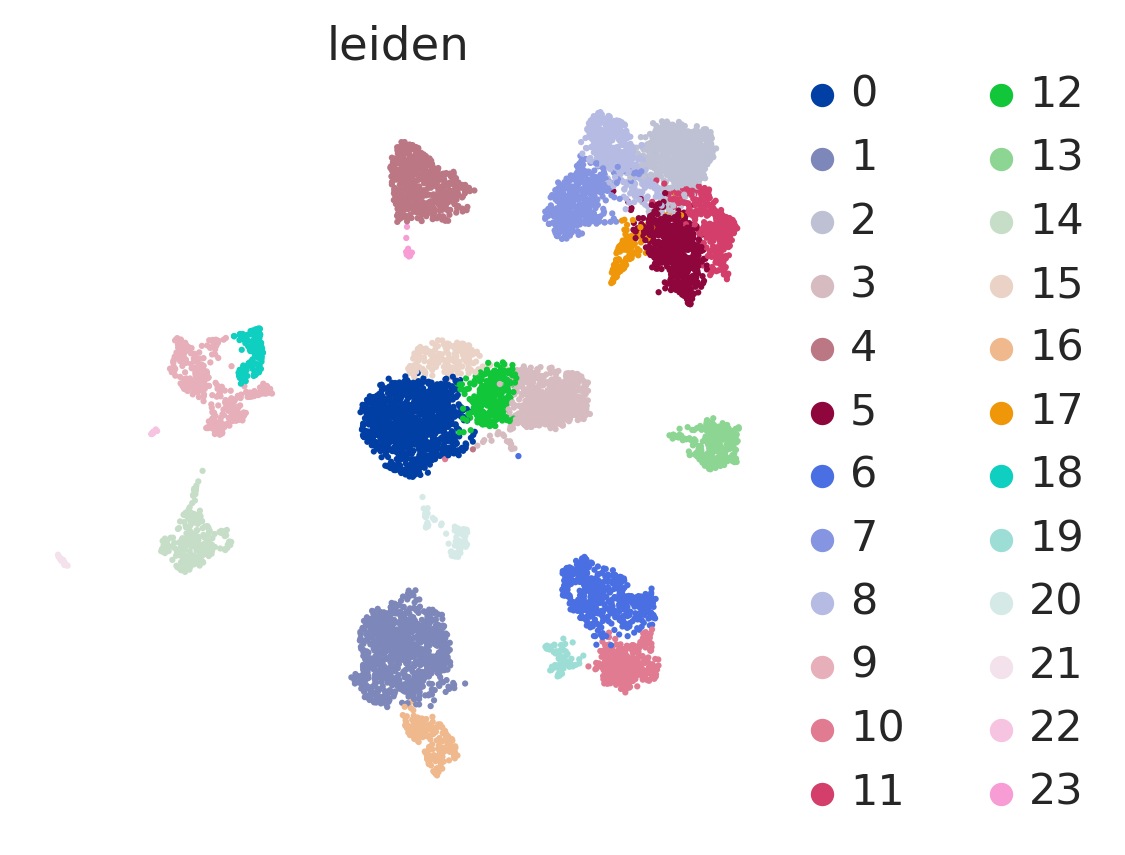

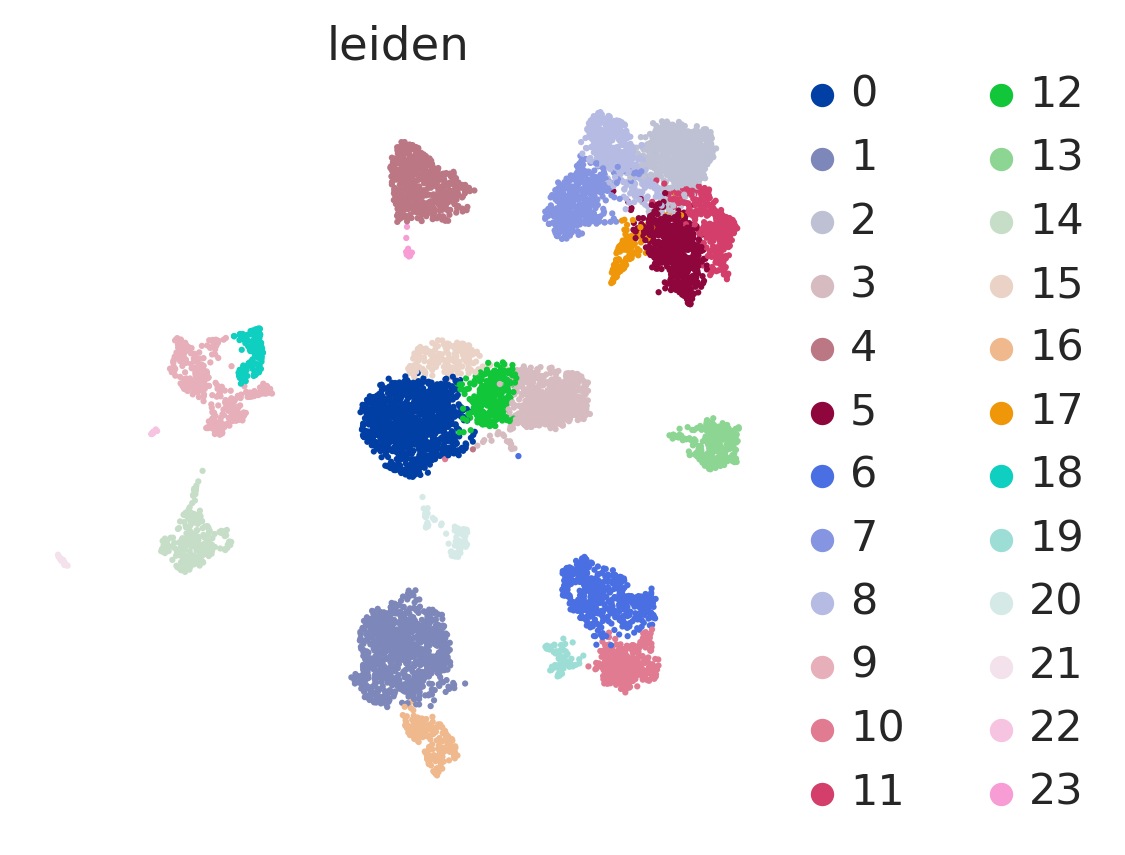

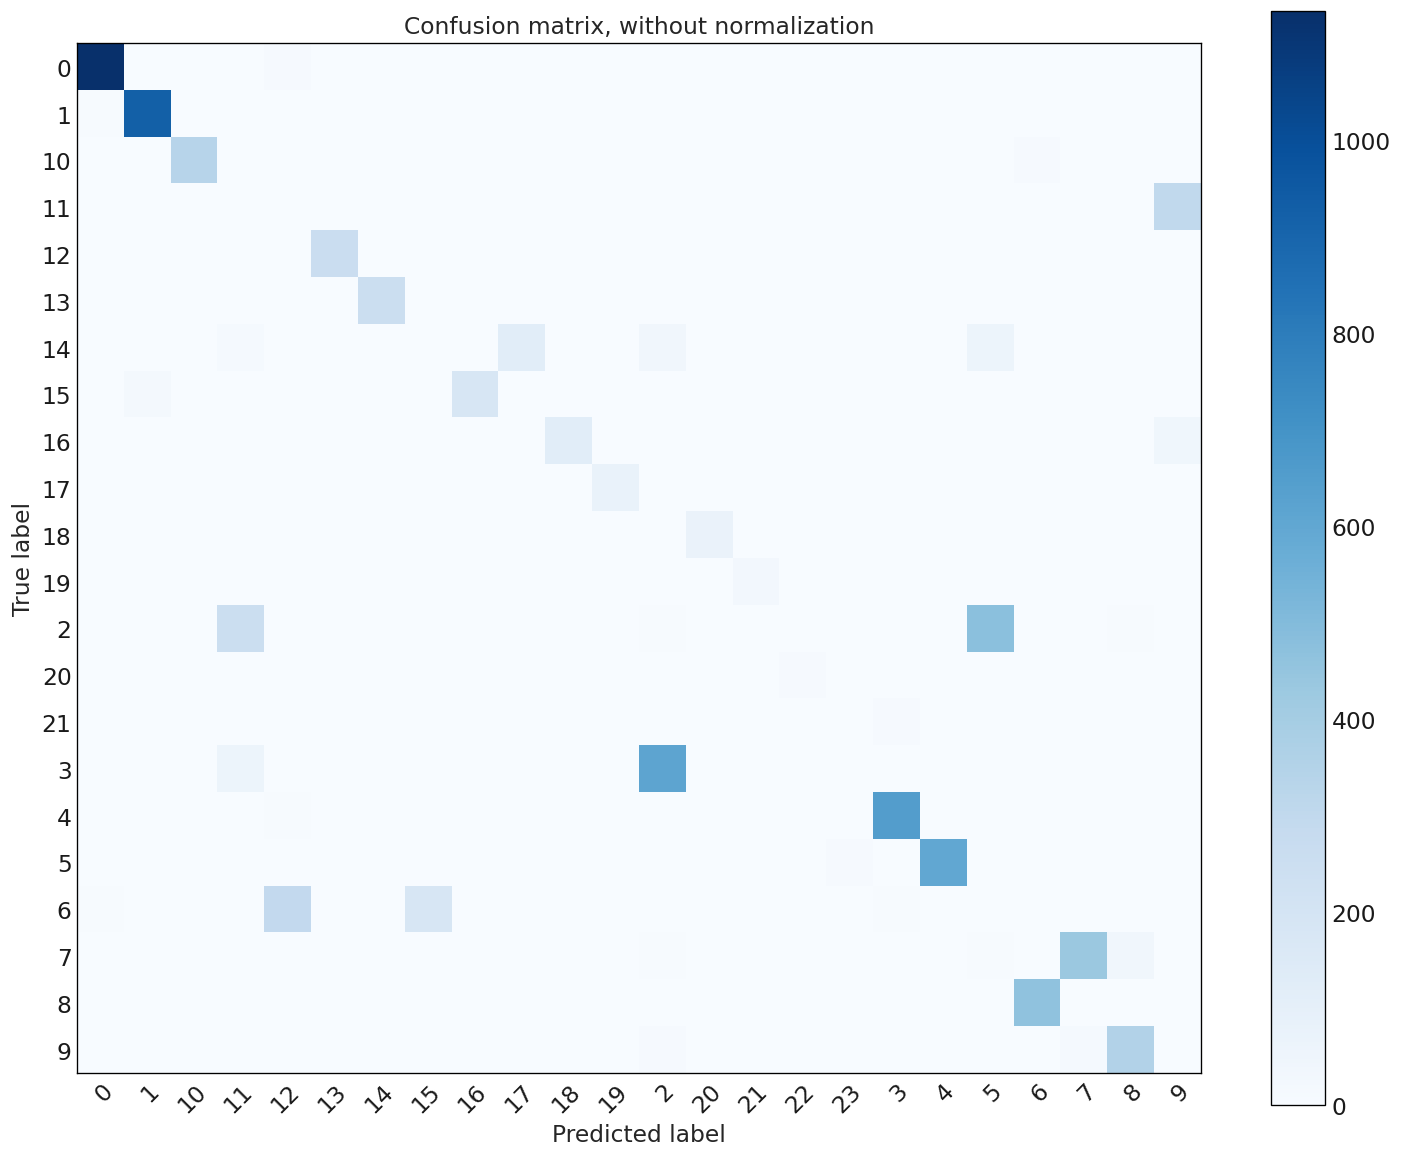

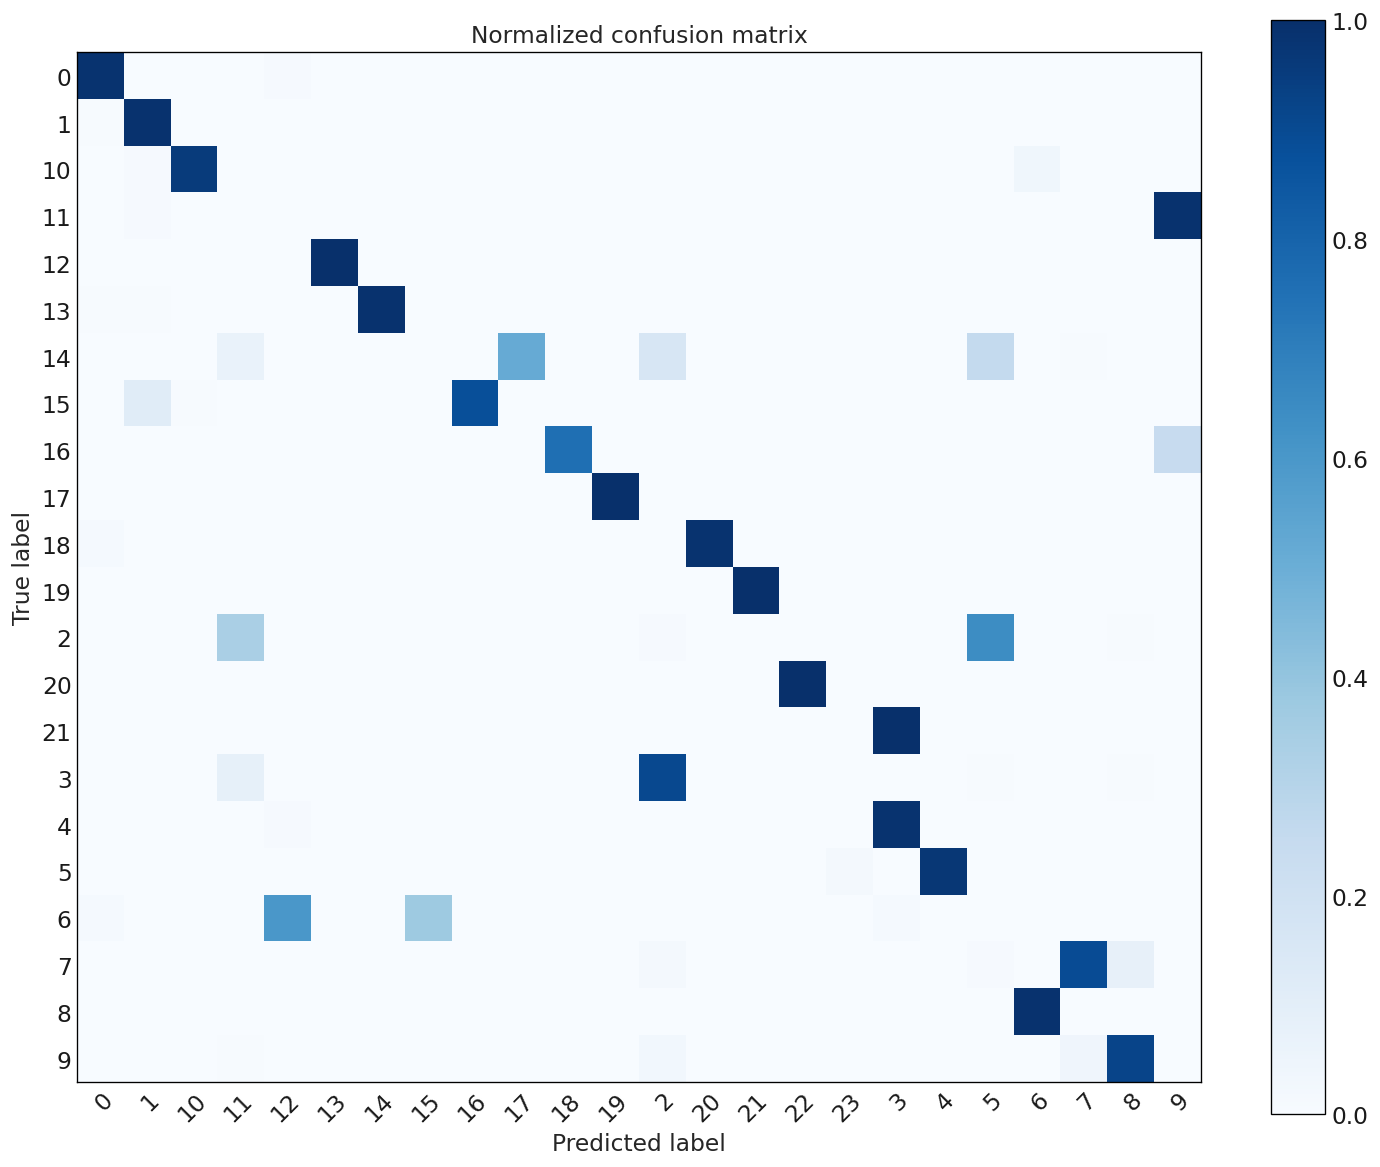

In [39]:
bc.tl.report(adata_pred=adata, celltype='leiden_std', method='without_regress_out', analysis_name=analysis_name,
                        test_dataset='adata_new', name_prediction='leiden', name_report='compare_leiden', use_raw=False,
                        remove_nonshared=False, clustering='leiden', asymmetric_matrix=True, delimiter='\t', verbose=True)

In [40]:
# Assess the original workflow and add new clustering for comparison
adata_std.obs = adata_std.obs.join(adata.obs['leiden'], rsuffix='_new')

acc: 0.33
f1: 0.33
ami: 0.91
ari: 0.89
silhouette leiden_new: 0.4
silhouette leiden: 0.46
pair confusion matrix:
          0        1
0  67675048   689238
1    418064  4636842


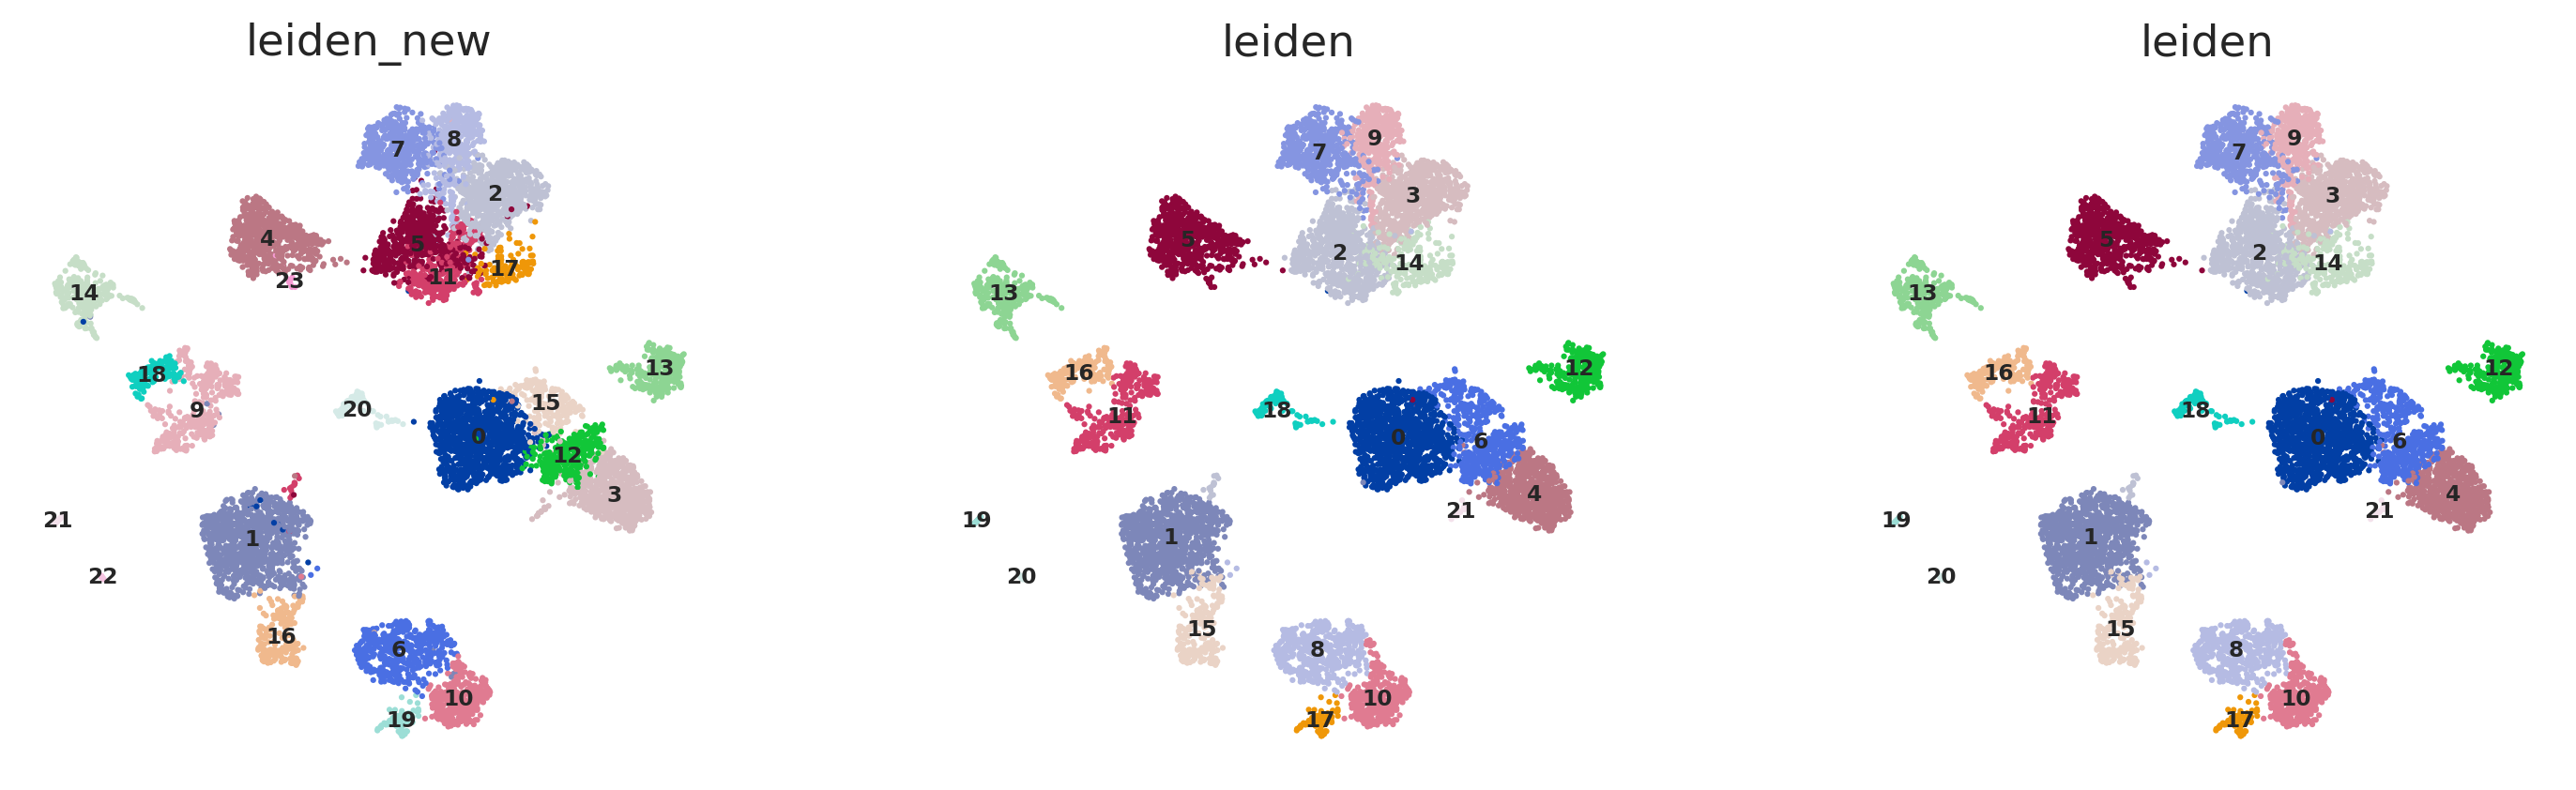

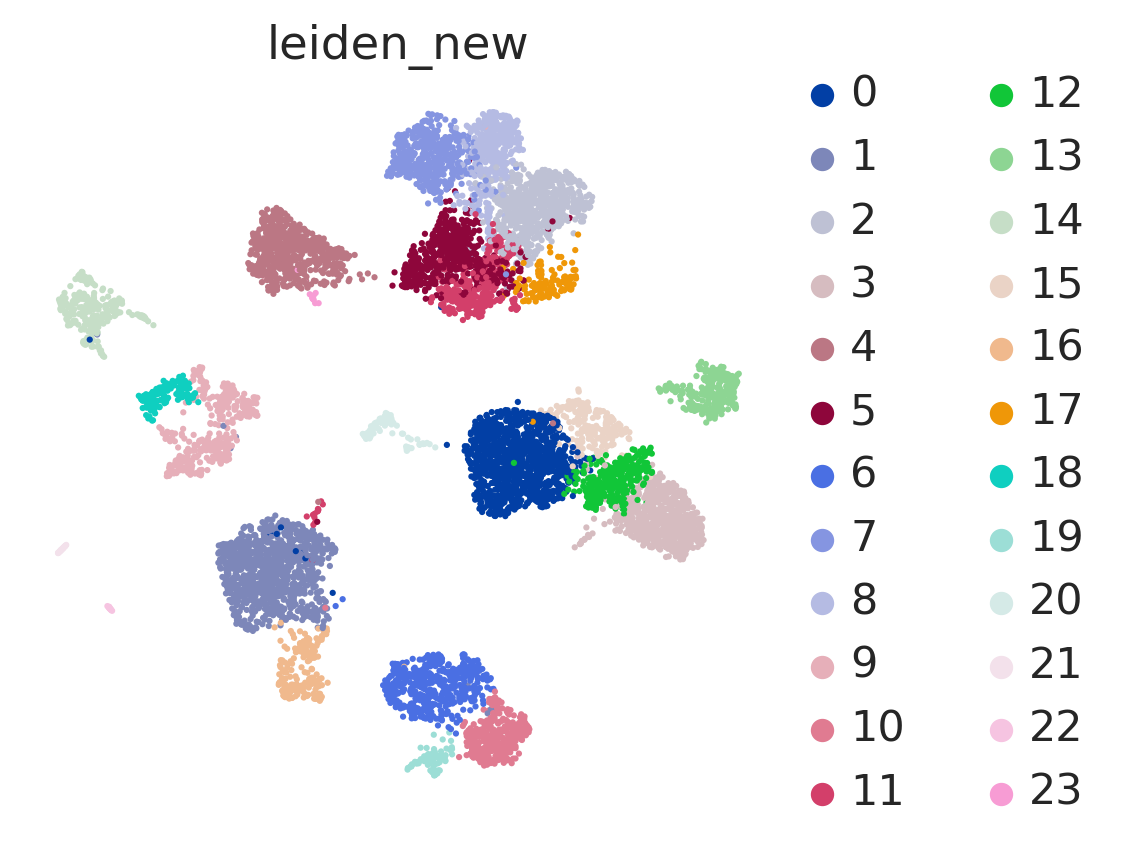

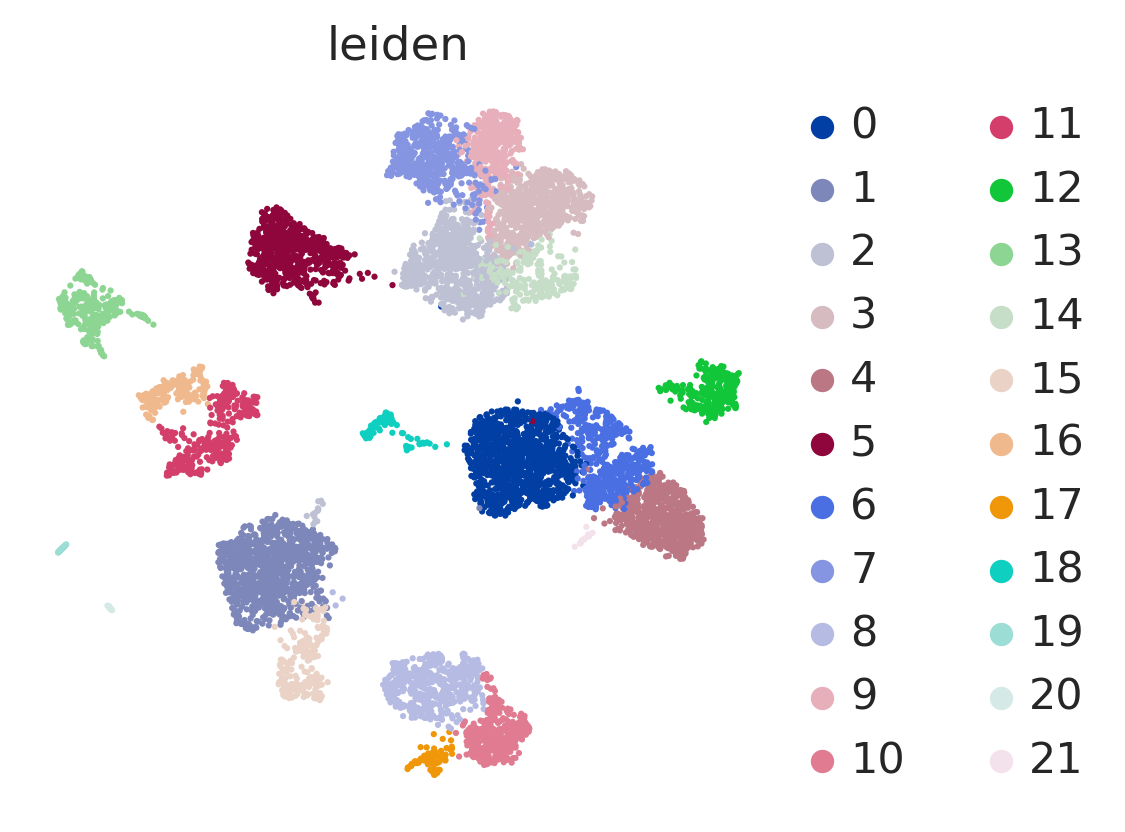

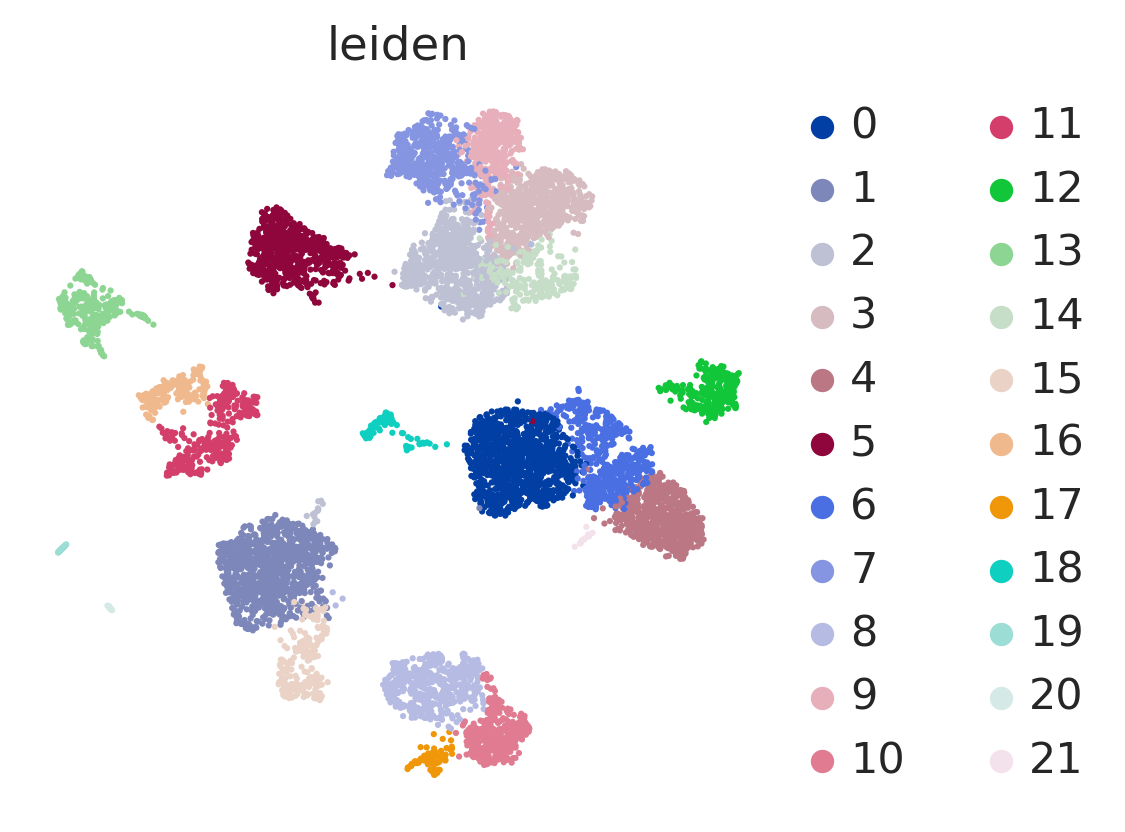

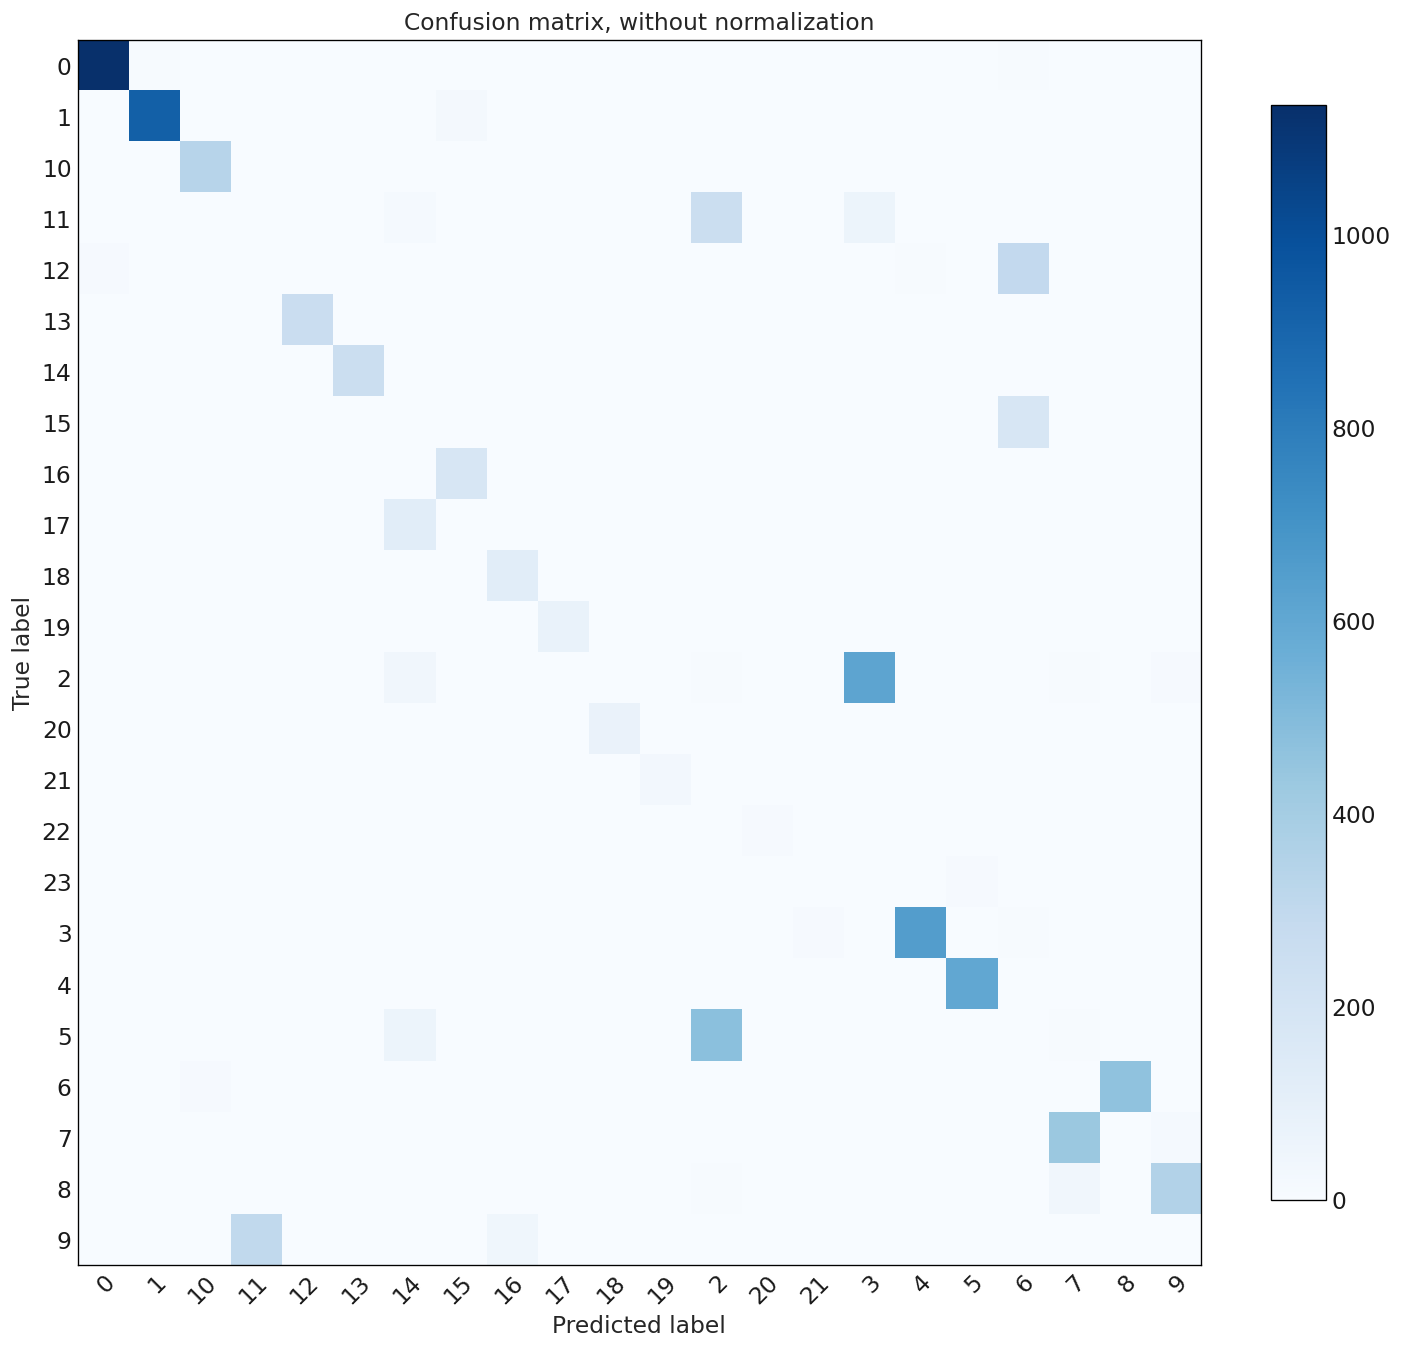

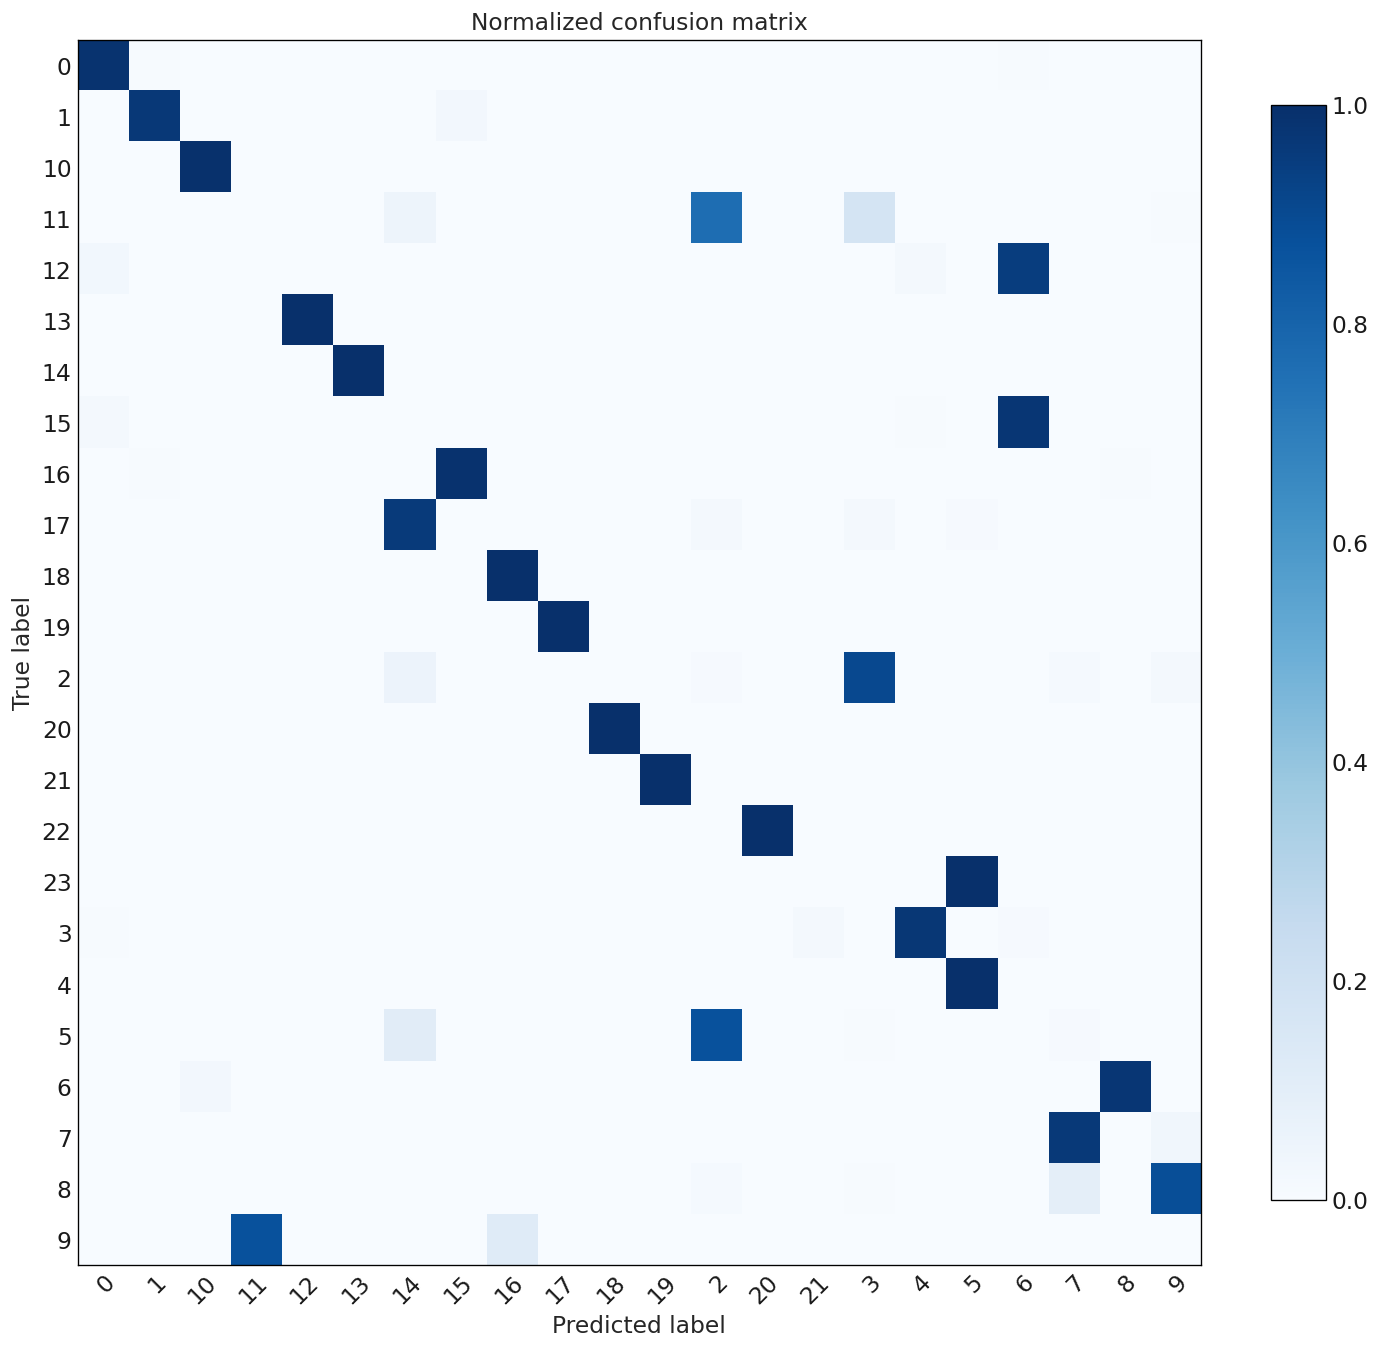

In [41]:
bc.tl.report(adata_pred=adata_std, celltype='leiden_new', method='without_regress_out', analysis_name='standard_workflow_besca2_0',
                        test_dataset='adata_std', name_prediction='leiden', name_report='compare_leiden', use_raw=False,
                        remove_nonshared=False, clustering='leiden', asymmetric_matrix=True, delimiter='\t', verbose=True)

In [42]:
# Read the results file from the regress out before hvg selection workflow
adata_reg_before_hvg = sc.read(os.path.join(results_folder, '..', 'standard_workflow_besca2.0_regress_out_before_hvg_selection/standard_workflow_besca2.0_regress_out_before_hvg_selection.h5ad'))
adata_reg_before_hvg

AnnData object with n_obs × n_vars = 8569 × 1688
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Individual_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [43]:
# Add clustering from the regress out before hvg selection workflow
adata.obs = adata.obs.join(adata_reg_before_hvg.obs['leiden'], rsuffix='_reg_before_hvg')

acc: 0.29
f1: 0.29
ami: 0.87
ari: 0.81
silhouette leiden_reg_before_hvg: 0.43
silhouette leiden: 0.45
pair confusion matrix:
          0        1
0  67089766   612298
1   1274520  4442608


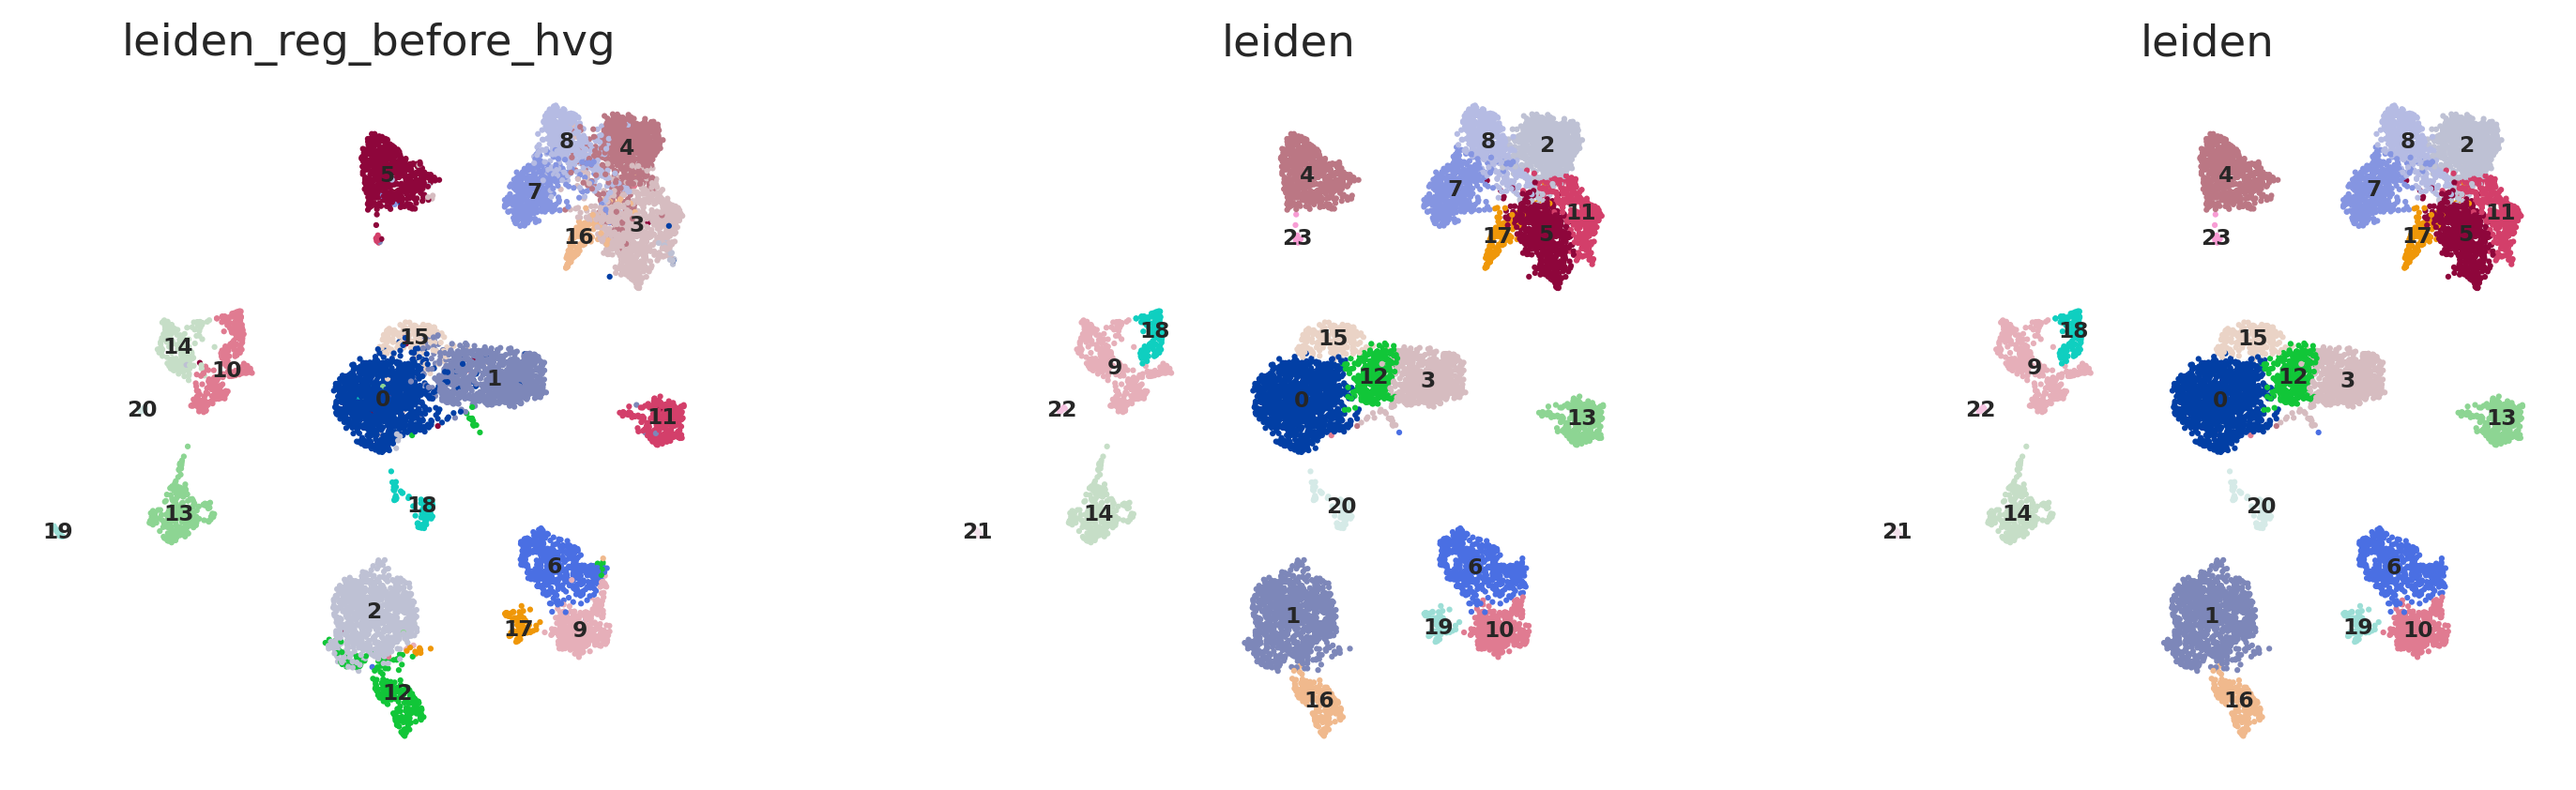

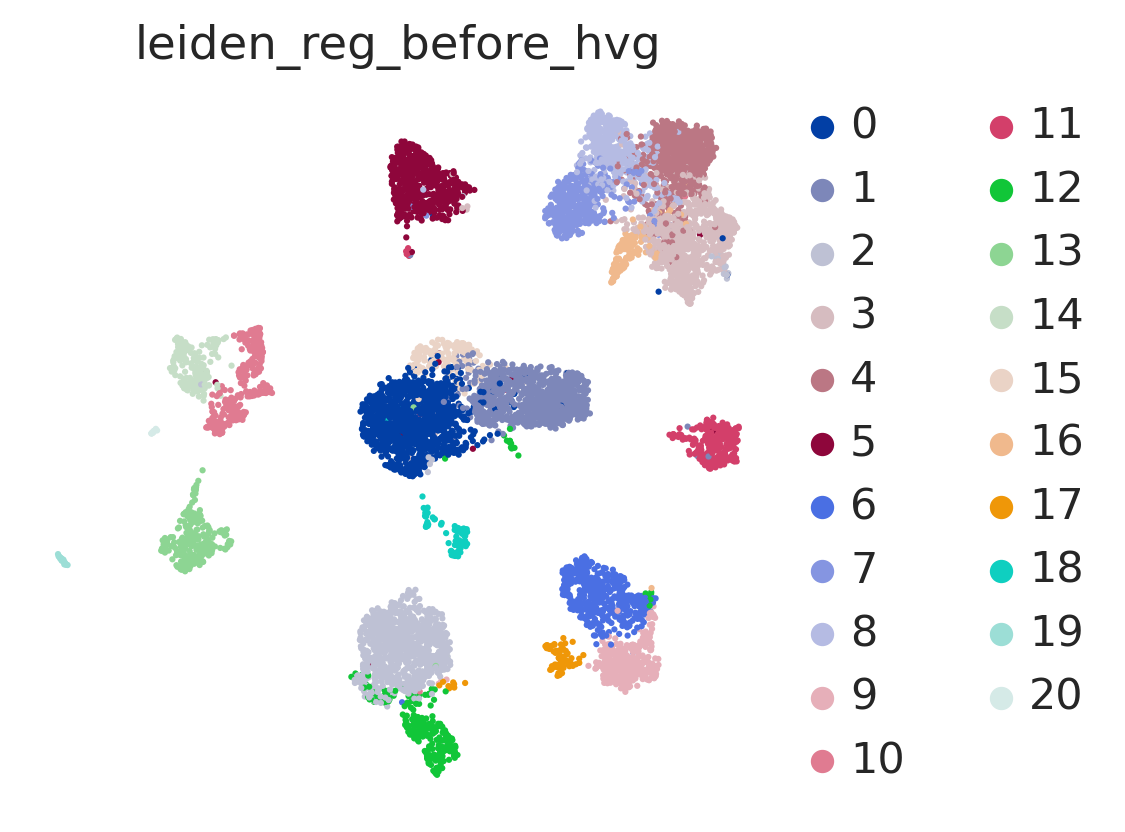

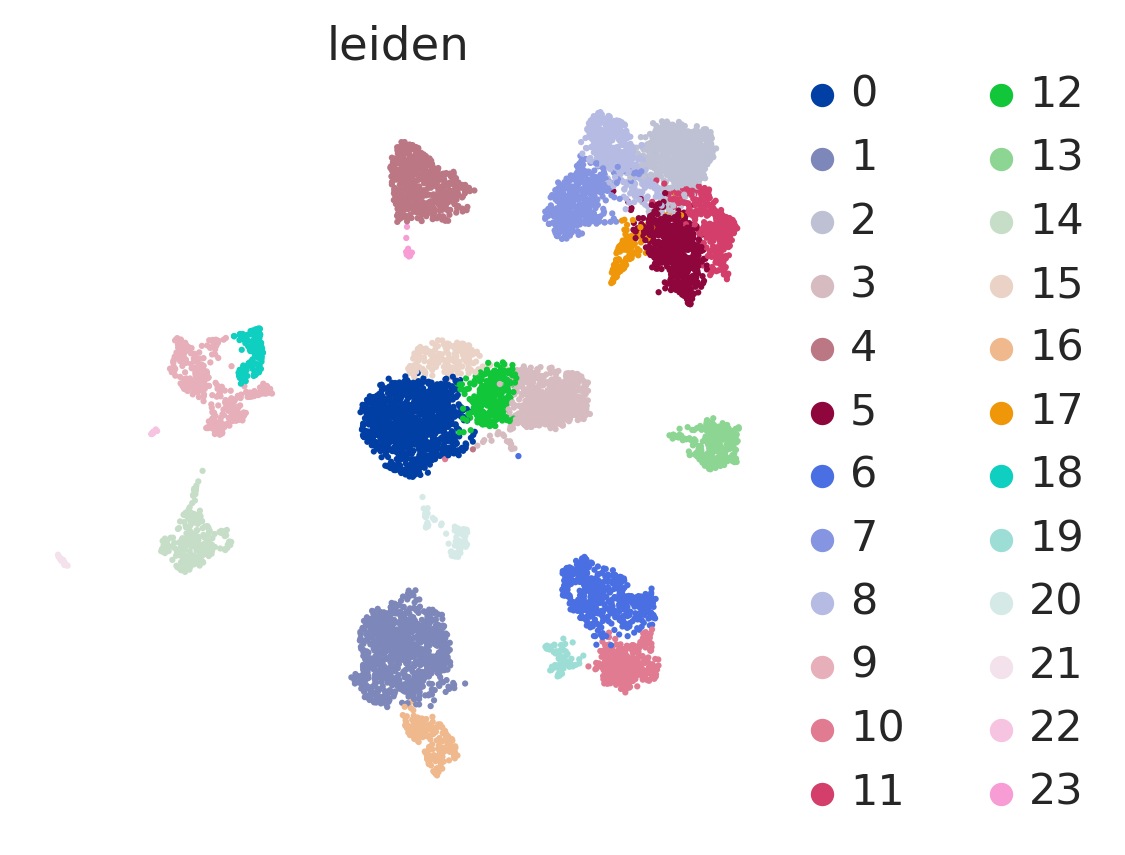

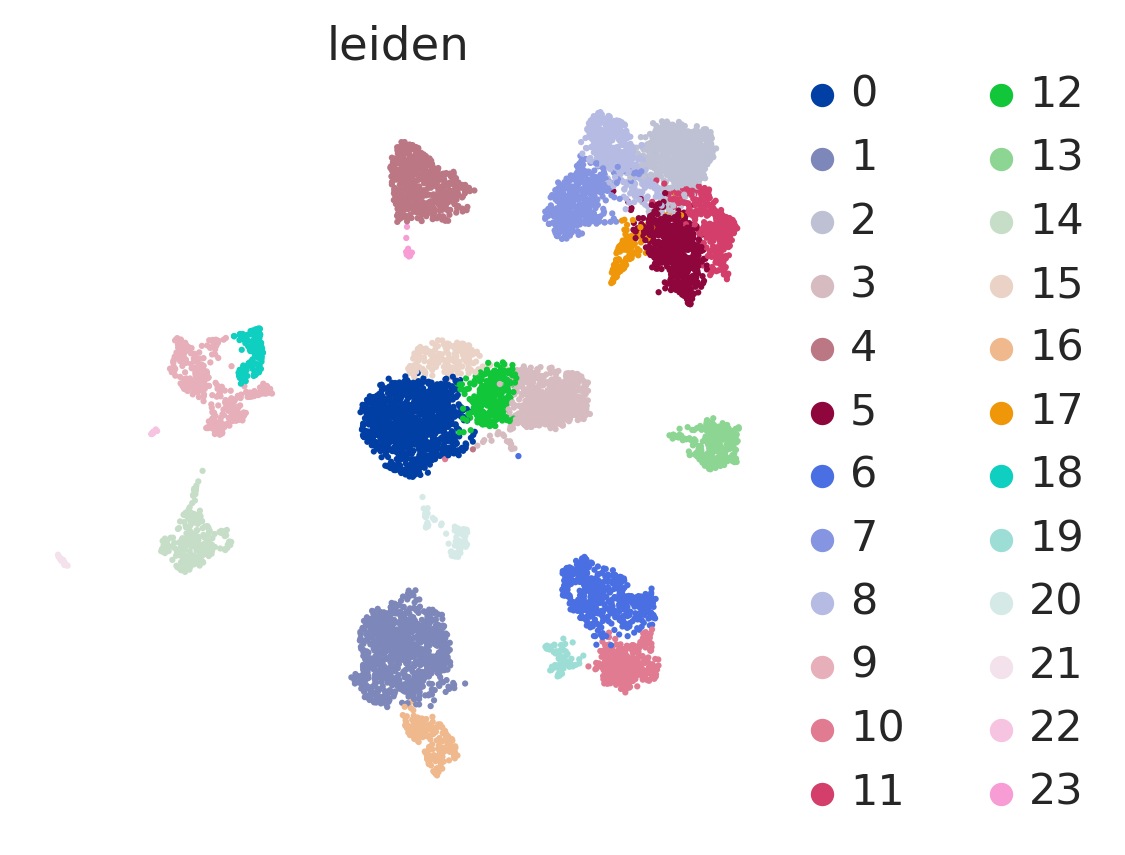

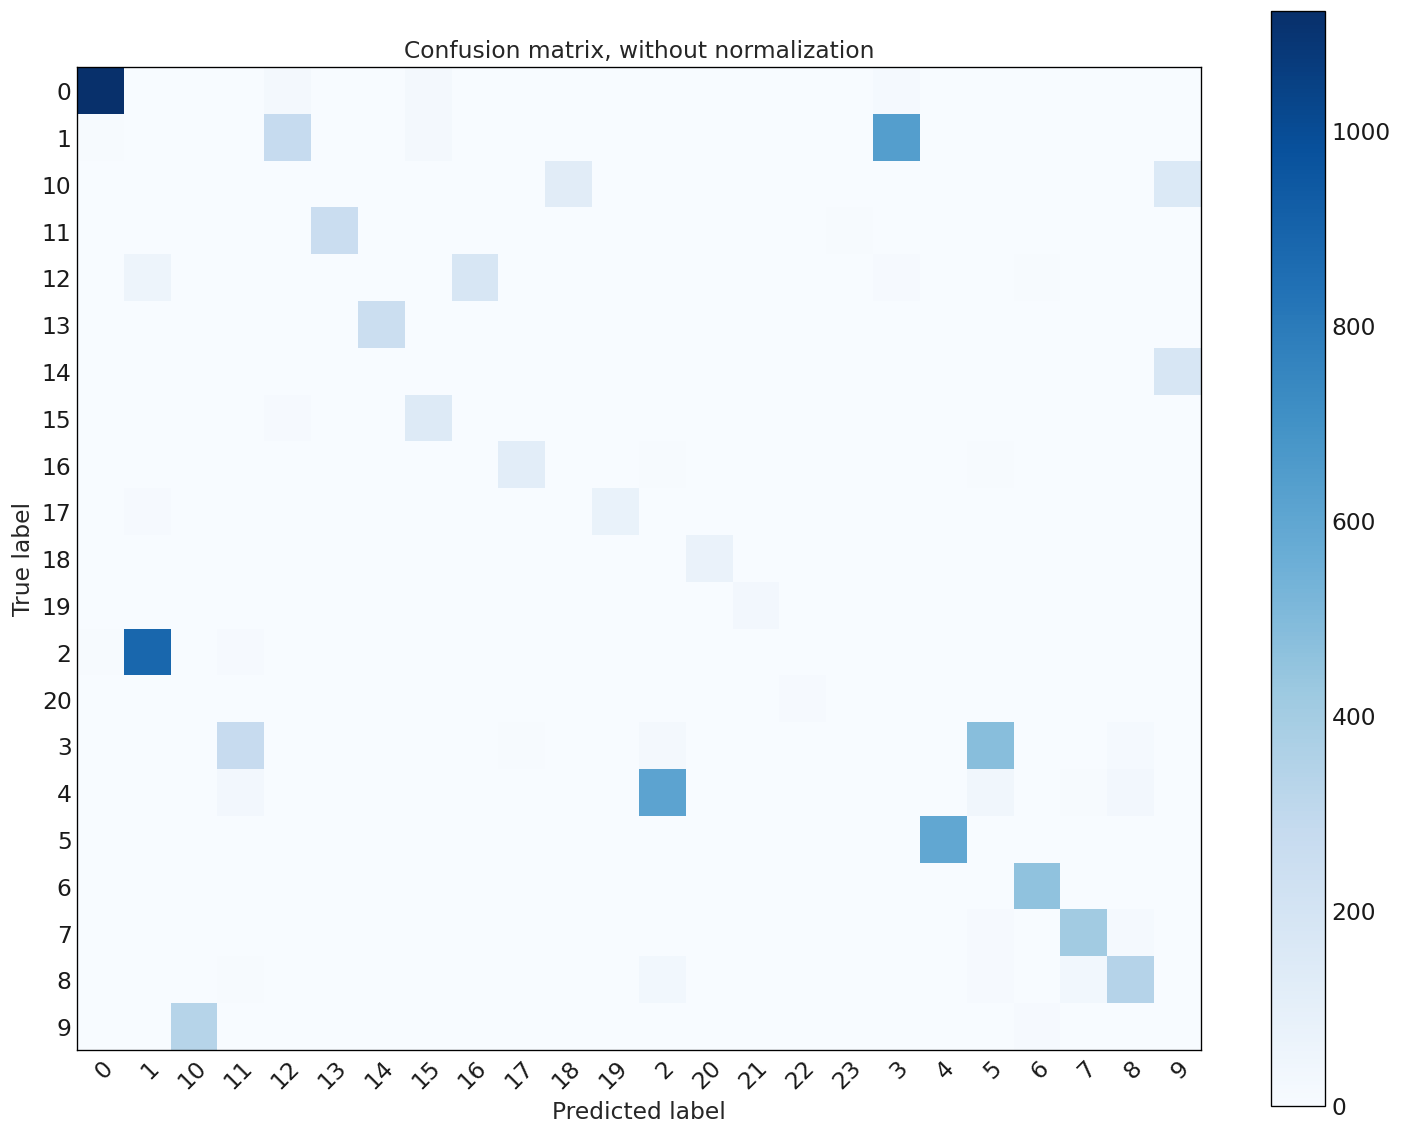

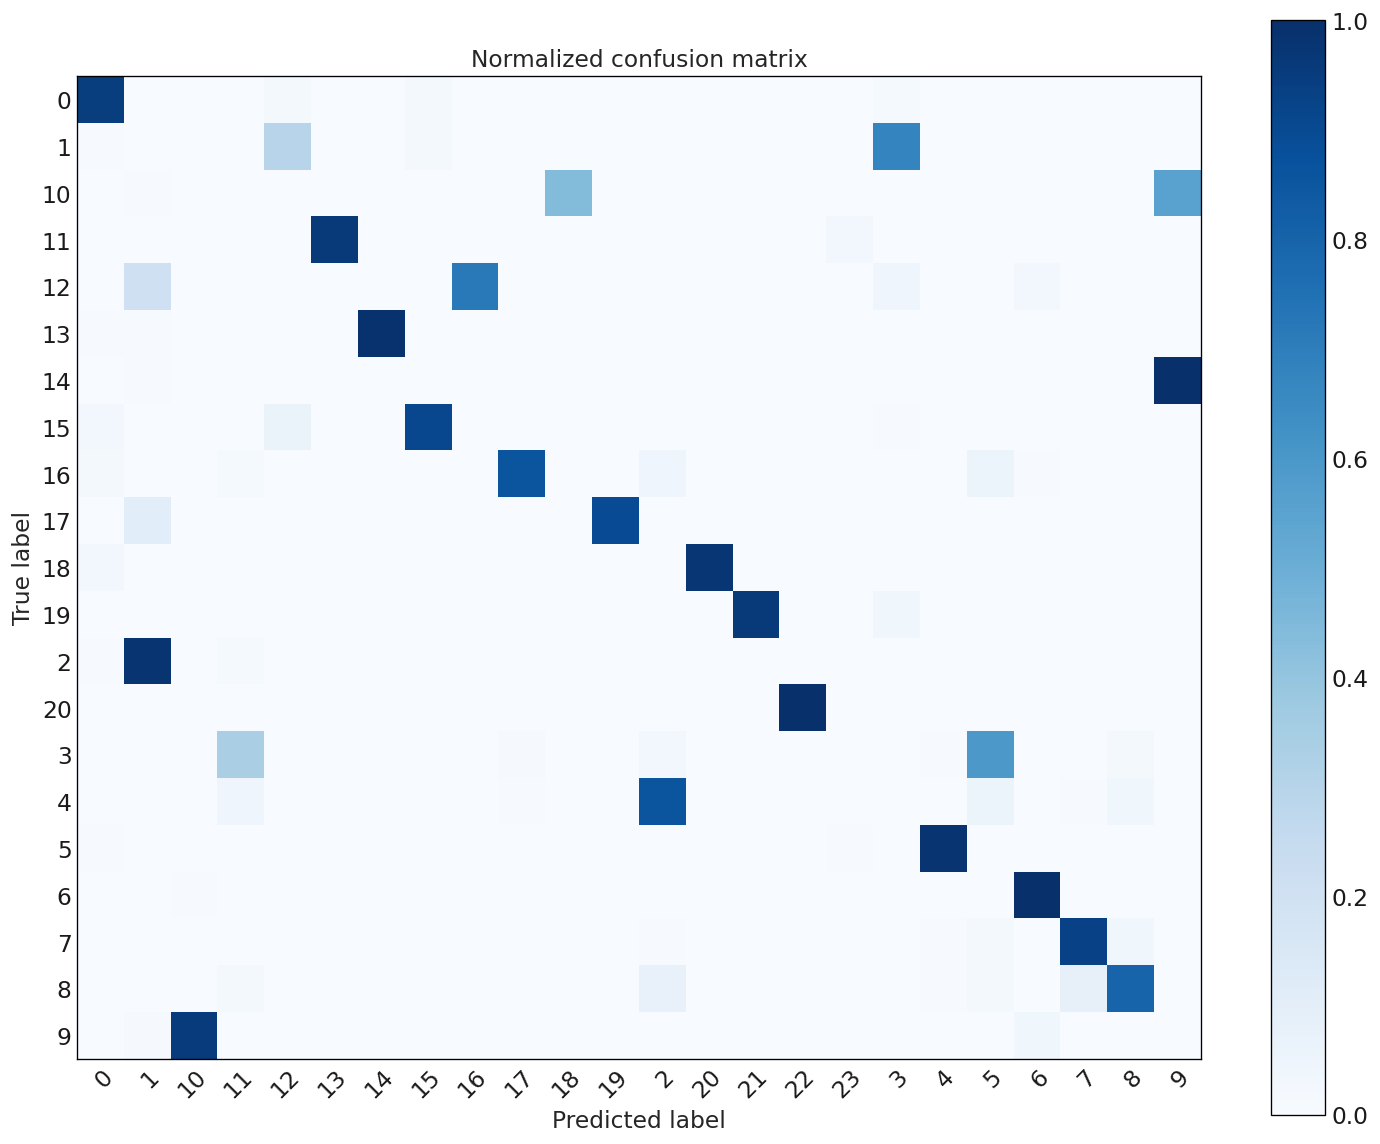

In [44]:
bc.tl.report(adata_pred=adata, celltype='leiden_reg_before_hvg', method='without_regress_out', analysis_name=analysis_name,
                        test_dataset='adata_new', name_prediction='leiden', name_report='compare_leiden', use_raw=False,
                        remove_nonshared=False, clustering='leiden', asymmetric_matrix=True, delimiter='\t', verbose=True)